In [16]:
# Import all the goods
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import iqr
import textwrap
plt.style.use('seaborn-whitegrid')

# Import the data files
xl_01 = pd.ExcelFile('20191014_HeartSurvey_edited.xlsx')
survey = xl_01.parse("Sheet1")
xl_02 = pd.ExcelFile('Survey questions key.xlsx')
survey_key = xl_02.parse("Sheet1")

## Extract observer risk scores to its own dataframe
risk = survey.iloc[:, 10:130:2].fillna(50).T ## All the actual questions, risk value
## Rename columns to match observer ID
risk.columns = [i+1 for i in range(18)]
## Rename indices to actual numbers, instead of the crazy codes
risk.index = [i for i in range(60)]

## Extract waitlist decision data to its own dataframe
decision = survey.iloc[:, 11:130:2].T ## All the actual questions, risk value
## Rename waitlist decision columns to match the risk columns
decision.columns = [i+1 for i in range(18)]

## Extract SRTR Risk scores
srtr_risk = pd.DataFrame(survey_key["SRTR Risk"])
## Create a scaled SRTR Risk key
scaler = MinMaxScaler(feature_range=(0,100))
scaled_srtr_risk = scaler.fit_transform(srtr_risk)
scaled_srtr_risk = pd.DataFrame(scaled_srtr_risk, columns=['Scaled SRTR Risk'])

# Create a master dataframe
## Add to the observer risk dataframe SRTR scores and Question IDs as extra columns
risk.insert(0,'Scaled SRTR Risk', scaled_srtr_risk)
risk.insert(0,'SRTR Risk', srtr_risk)
risk.insert(0,'Scenario ID', [i+1 for i in range(60)])

## Unpivot the observer risk dataframe
data_temp = pd.melt(risk, id_vars=['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk'], var_name='Observer ID', value_name='Observer Risk')
## Add to the unpivoted table all the decisions
data_temp.insert(0,'Observer Decision', pd.melt(decision).value)
## Finally, reorganize the columns
master_data = data_temp[['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk', 'Observer ID', 'Observer Risk', 'Observer Decision']]
## Categorize scenarios 1-30 and 31-60 as A and B
scenario_set = np.where(master_data['Scenario ID'] <= 30, 'No SRTR Score', 'With SRTR Score')
master_data.insert(1, 'Scenario Set', scenario_set)

master_data.describe()

,Scenario ID,SRTR Risk,Scaled SRTR Risk,Observer Risk
count,1080.000000,1080.000000,1080.000000,1080.000000
mean,30.500000,14.113667,40.843436,66.893519
std,17.326125,7.526083,29.433253,25.395495
min,1.000000,3.670000,0.000000,0.000000
25%,15.750000,6.785000,12.182245,54.000000
50%,30.500000,12.830000,35.823230,73.000000
75%,45.250000,20.312500,65.086038,85.250000
max,60.000000,29.240000,100.000000,100.000000


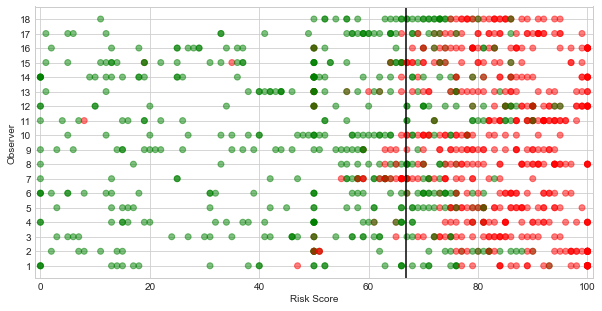

In [2]:
# All scenarios stacked into one chart, with a Mean of Means line thrown in
plt.rcParams['figure.figsize'] = [10, 5]
x = master_data['Observer Risk']
y = master_data['Observer ID']
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.scatter(x, y, marker='o', color=colors, alpha=0.5)
plt.axvline(x=master_data['Observer Risk'].mean(), color='black')
plt.xlim(-1, 101)
plt.ylabel('Observer')
plt.xlabel('Risk Score')
plt.yticks([i+1 for i in range(18)])
;

plt.savefig('AllResults.jpg')

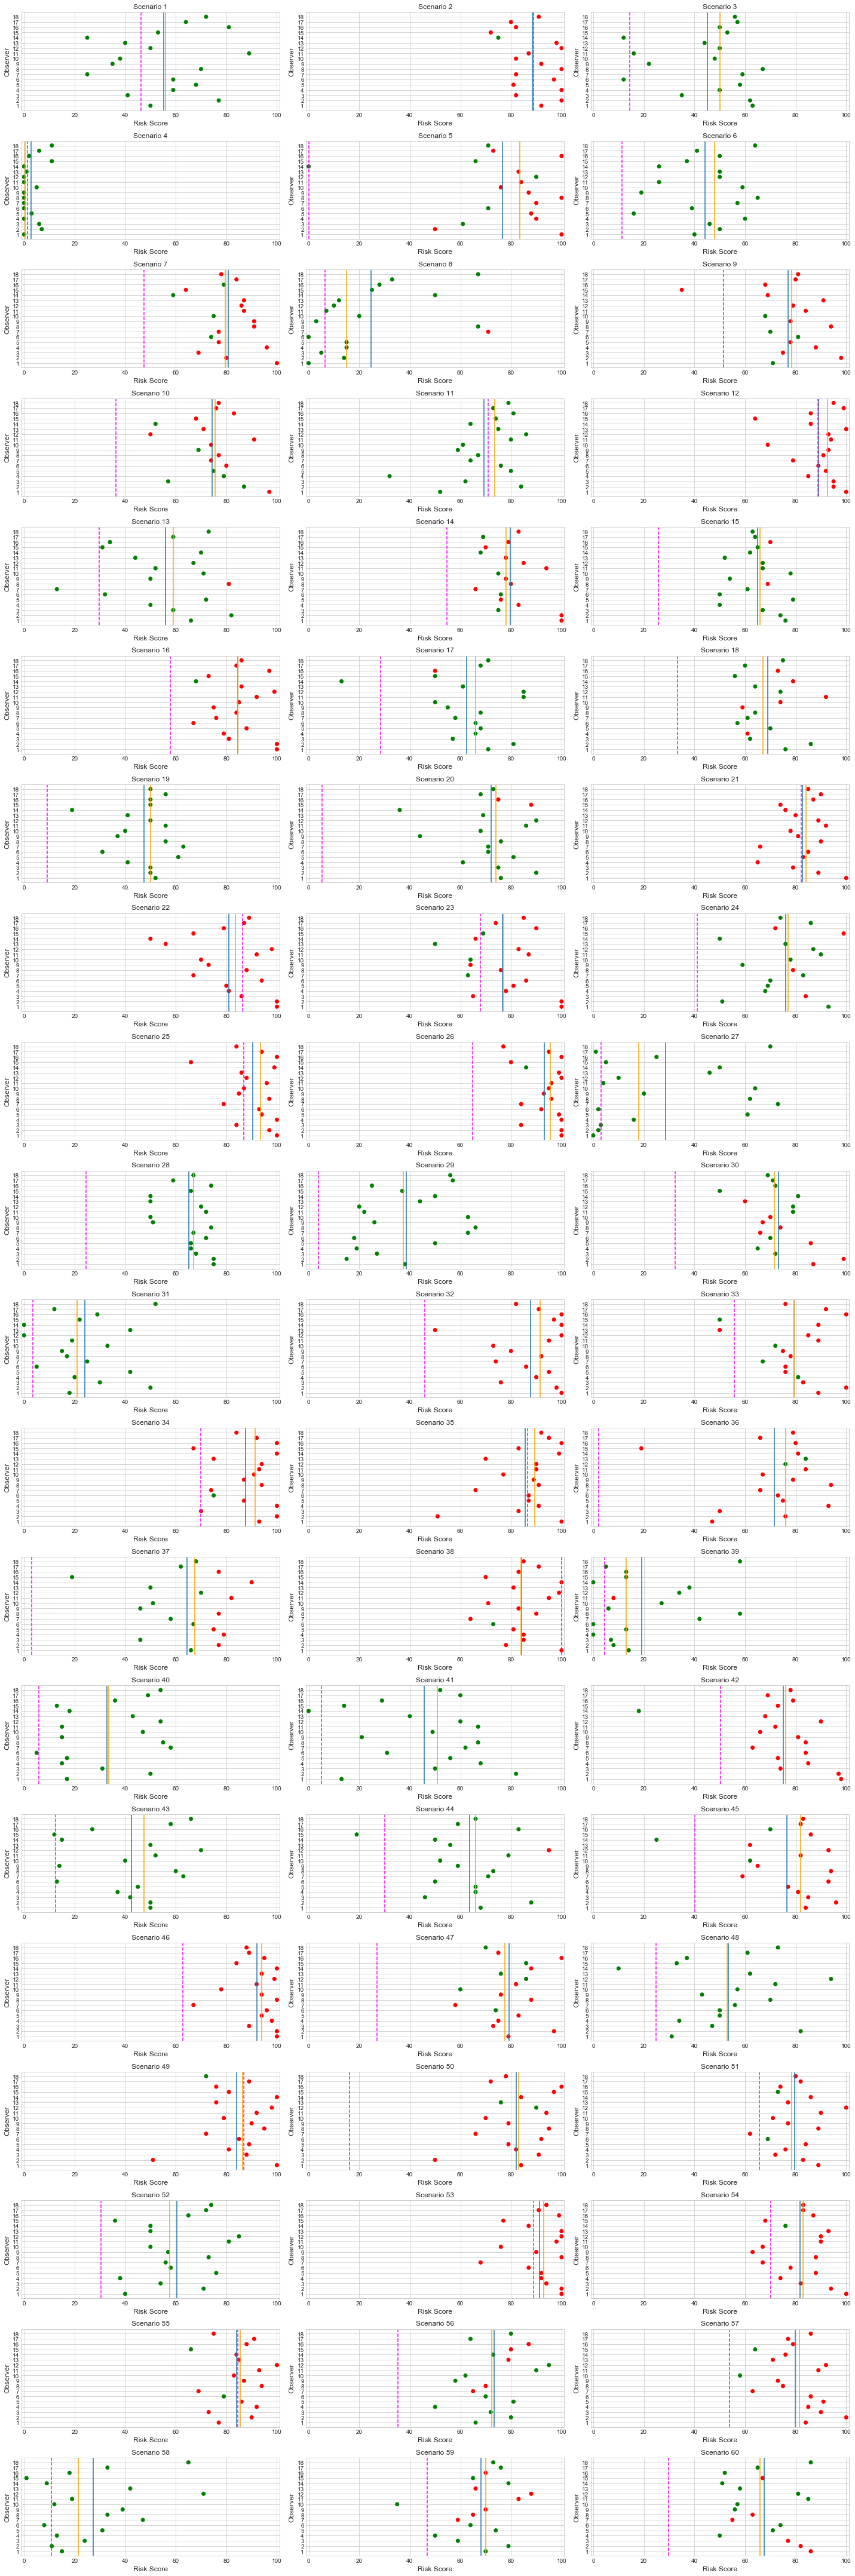

In [3]:
## Plot observer risk/decision for each scenario
#    Mean = blue line
#    Median = orange line
#    Scaled SRTR risk = dotted magenta line

def plotAllScenarios(df):
    plt.rcParams['figure.figsize'] = [20, 60]
    fig, axs = plt.subplots(20, 3)
    scenario = 1
    for i in range(20):
        for j in range(3):
            risk     = df[df['Scenario ID'] == scenario]['Observer Risk']
            observer = df[df['Scenario ID'] == scenario]['Observer ID']
            colors   = df[df['Scenario ID'] == scenario]['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])
            srtr     = df[df['Scenario ID'] == scenario]['Scaled SRTR Risk'].max()
            axs[i, j].set_xlim([-1, 101])
            axs[i, j].scatter(risk, observer, color=colors)
            axs[i, j].axvline(x=risk.mean())
            axs[i, j].axvline(x=risk.median(), color='orange')
            axs[i, j].axvline(x=srtr, color='magenta', linestyle='--')
            axs[i, j].set_title(f'Scenario {scenario}', fontsize='large')
            axs[i, j].set_ylabel('Observer', fontsize='large')
            axs[i, j].set_xlabel('Risk Score', fontsize='large')
            axs[i, j].set_yticks([i+1 for i in range(18)])
            scenario += 1
    plt.tight_layout()
    
plotAllScenarios(master_data)

plt.savefig('AllScenarios.jpg')

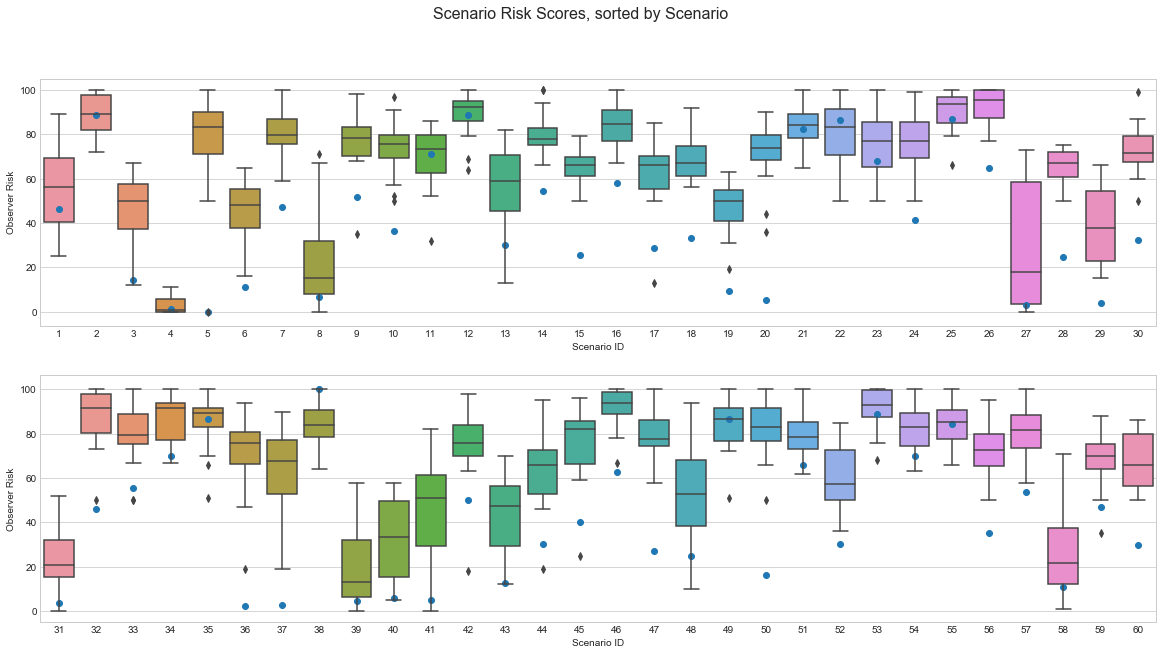

In [4]:
def results_sorted_by_srtr(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.sort_values('Scaled SRTR Risk')
    results_b_sorted =     results_b.sort_values('Scaled SRTR Risk')
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Scaled SRTR Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

def results_sorted_by_mean(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.groupby('Scenario ID').mean().sort_values('Observer Risk').reset_index()
    results_b_sorted =     results_b.groupby('Scenario ID').mean().sort_values('Observer Risk').reset_index()
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Mean Observer Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

def results_sorted_by_median(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted =     results_a.groupby('Scenario ID').median().sort_values('Observer Risk').reset_index()
    results_b_sorted =     results_b.groupby('Scenario ID').median().sort_values('Observer Risk').reset_index()
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Median Observer Risk Score',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }


def results_sorted_by_scenario(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_a_sorted = results_a
    results_b_sorted = results_b
    results_a_sort_order = results_a_sorted['Scenario ID'].drop_duplicates()
    results_b_sort_order = results_b_sorted['Scenario ID'].drop_duplicates()
    srtr_a_sorted = results_a_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_a_sorted.index = [i for i in range(30)]
    srtr_b_sorted = results_b_sorted[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Scenario',
        'first_results': results_a,
        'first_results_sorted': results_a_sorted,
        'first_results_sort_order': results_a_sort_order,
        'first_srtr_sorted': srtr_a_sorted,
        'second_results': results_b,
        'second_results_sorted': results_b_sorted,
        'second_results_sort_order': results_b_sort_order,
        'second_srtr_sorted': srtr_b_sorted
    }

def results_sorted_by_interquartitle_range(df):
    from scipy.stats import iqr
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
    # Make two lists of interquartile ranges
    iqr_list = []
    for scenario in df['Scenario ID']:
        iqr_list.append(iqr(df[df['Scenario ID'] == scenario]['Observer Risk']))
    iqr_df = pd.DataFrame(iqr_list, columns=['IQR'])
    iqr_df = iqr_df[:60]
    iqr_df.insert(0, 'Scenario ID', [i+1 for i in range(60)])
    iqr_df.insert(2, 'Scaled SRTR Risk', df[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scaled SRTR Risk'])
    iqr_a = iqr_df[:30]
    iqr_b = iqr_df[30:]
    results_a_sorted = iqr_a.sort_values('IQR')
    results_a_sort_order = results_a_sorted['Scenario ID']
    srtr_a_sorted = results_a_sorted
    srtr_a_sorted.index = [i for i in range(30)]
    results_b_sorted = iqr_b.sort_values('IQR')
    results_b_sort_order = results_b_sorted['Scenario ID']
    srtr_b_sorted = results_b_sorted
    srtr_b_sorted.index = [i for i in range(30)]
    return {
        'title':                      'Interquartile Range',
        'first_results':              results_a,
        'first_results_sorted':       results_a_sorted,
        'first_results_sort_order':   results_a_sort_order,
        'first_srtr_sorted':          srtr_a_sorted,
        'second_results':             results_b,
        'second_results_sorted':      results_b_sorted,
        'second_results_sort_order':  results_b_sort_order,
        'second_srtr_sorted':         srtr_b_sorted
    }

    
def boxplot_survey(df, sort_by='scenario'):
    plt.figure(figsize=(20, 10))
    if (sort_by == 'mean'):
        results = results_sorted_by_mean(df)
    if (sort_by == 'scenario'):
        results = results_sorted_by_scenario(df)
    if (sort_by == 'srtr'):
        results = results_sorted_by_srtr(df)
    if (sort_by == 'median'):
        results = results_sorted_by_median(df)
    if (sort_by == 'iqr'):
        results = results_sorted_by_interquartitle_range(df)
    first_results = results['first_results']
    first_results_sorted = results['first_results_sorted']
    first_results_sort_order = results['first_results_sort_order']
    first_srtr_sorted = results['first_srtr_sorted']
    second_results = results['second_results']
    second_results_sorted = results['second_results_sorted']
    second_results_sort_order = results['second_results_sort_order']
    second_srtr_sorted = results['second_srtr_sorted']

    plt.subplot(2, 1, 1)
    ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=first_results, order=first_results_sort_order)
    ax_1 = plt.scatter(first_srtr_sorted.index.values, first_srtr_sorted['Scaled SRTR Risk'])
    
    plt.subplot(2, 1, 2)
    ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=second_results, order=second_results_sort_order)
    ax_2 = plt.scatter(second_srtr_sorted.index.values, second_srtr_sorted['Scaled SRTR Risk'])
    
    plt.suptitle(f'Scenario Risk Scores, sorted by {results["title"]}', fontsize=16)



boxplot_survey(master_data)

plt.savefig('plot_BoxPerScenario.jpg')



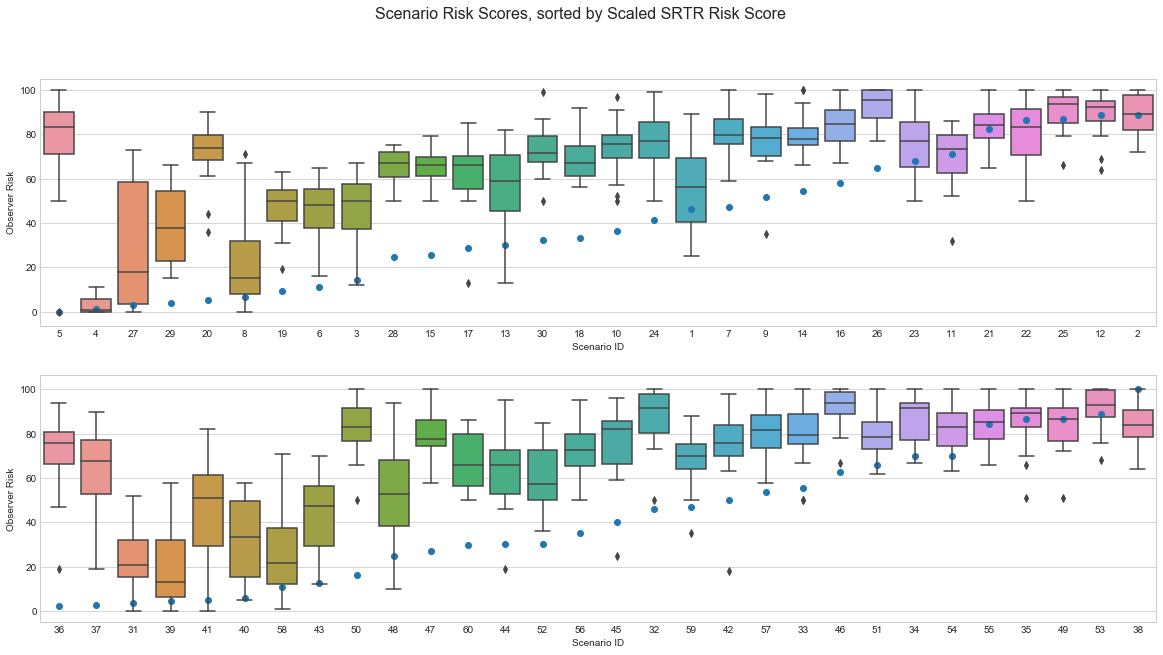

In [5]:
boxplot_survey(master_data, 'srtr')
plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

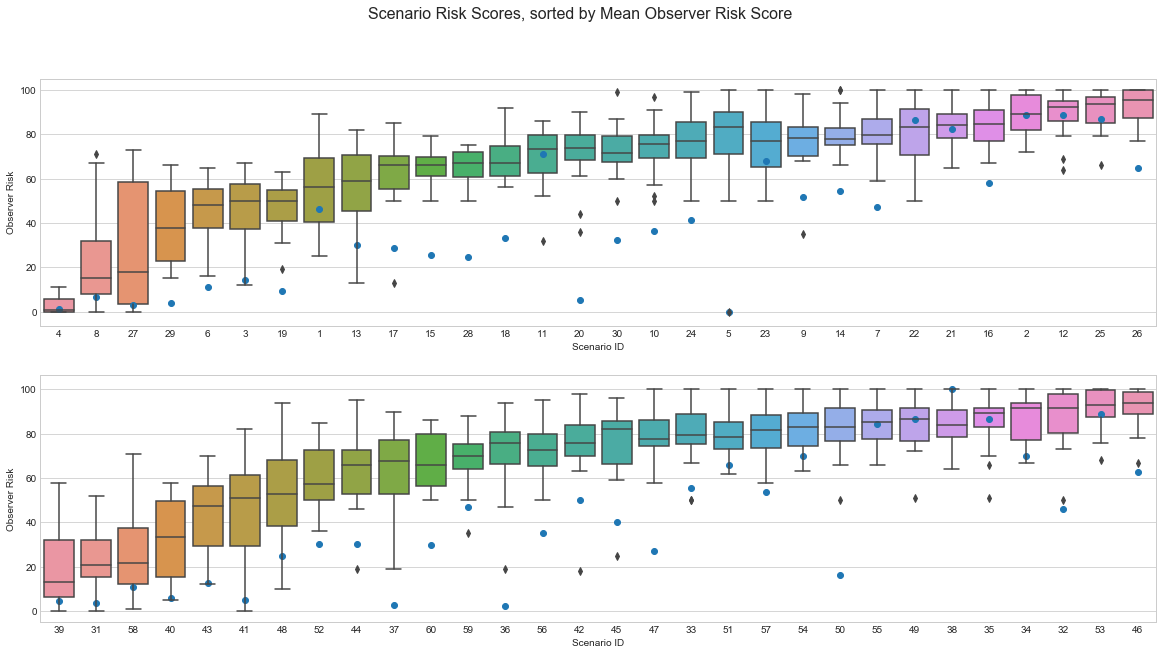

In [6]:
boxplot_survey(master_data, 'mean')
plt.savefig('plot_BoxPerScenario_sortMean.jpg')

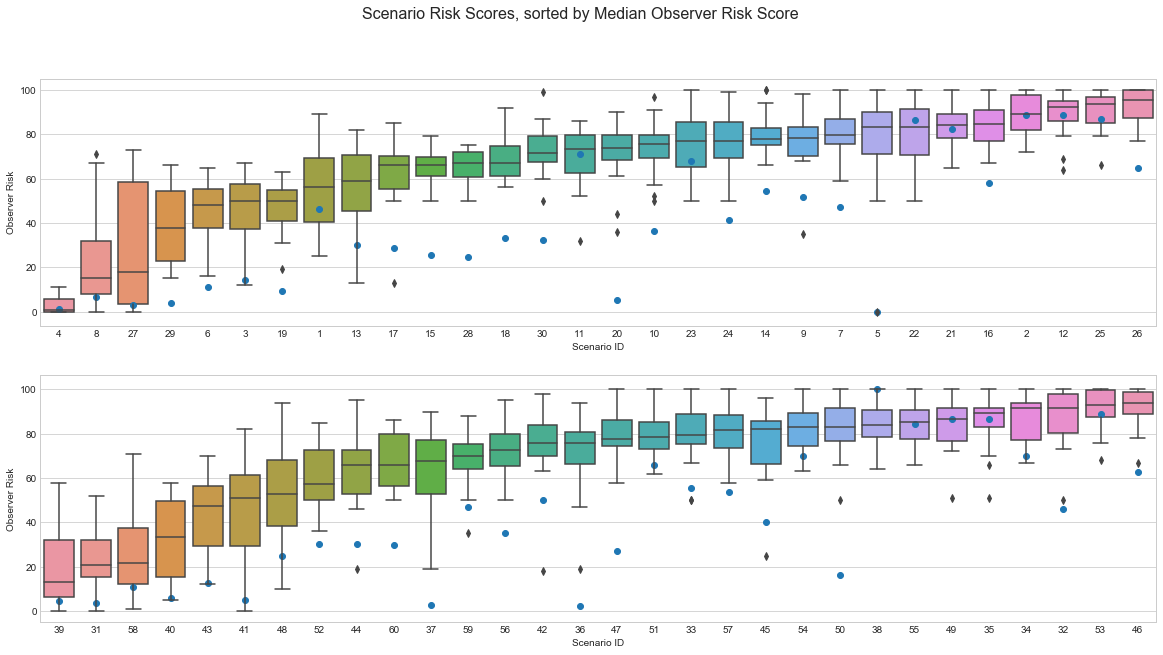

In [7]:
boxplot_survey(master_data, 'median')
plt.savefig('plot_BoxPerScenario_sortMedian.jpg')

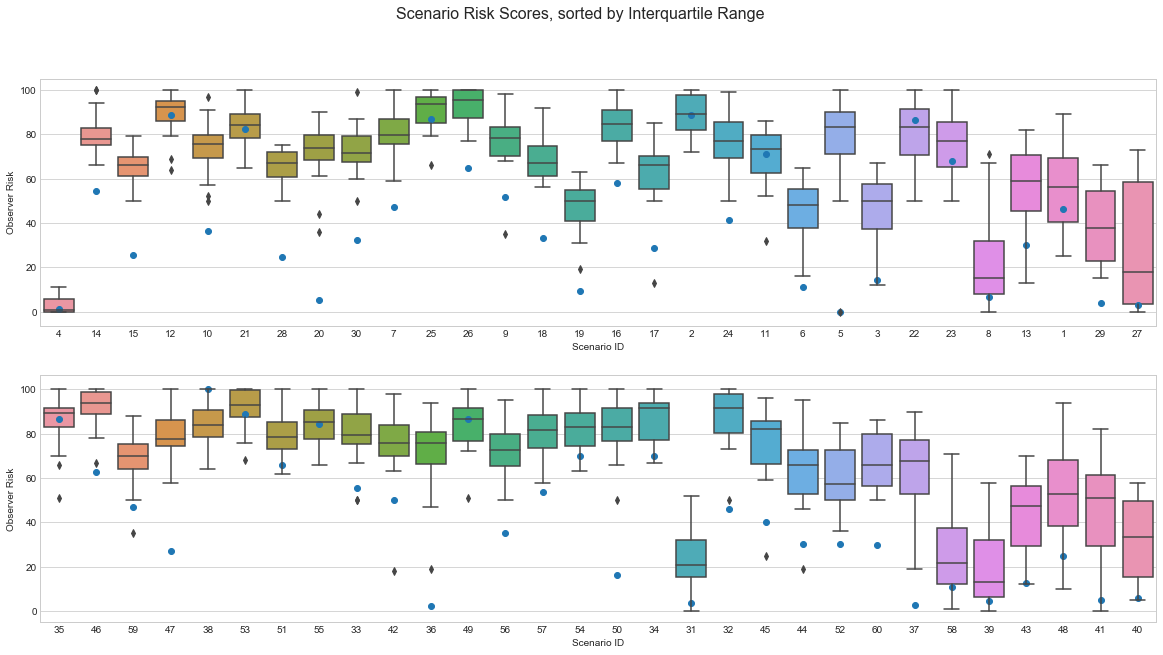

In [8]:
boxplot_survey(master_data, 'iqr')
plt.savefig('plot_BoxPerScenario_sortIQR.jpg')

In [9]:
def results_sliced_by_decision(df):
    results_a = df.loc[(df['Scenario ID'] <= 30)][['Scenario ID', 'Observer ID', 'Observer Risk', 'Observer Decision', 'Scaled SRTR Risk']]
    results_a_yes = results_a[results_a['Observer Decision'] == 'Yes']
    results_a_no = results_a[results_a['Observer Decision'] == 'No']
    results_b = df.loc[(df['Scenario ID'] > 30)][['Scenario ID', 'Observer ID', 'Observer Risk', 'Observer Decision', 'Scaled SRTR Risk']]
    results_b_yes = results_b[results_b['Observer Decision'] == 'Yes']
    results_b_no = results_b[results_b['Observer Decision'] == 'No']
    return {
        'title':               'Sliced by Decision',
        'first_set':       results_a,
        'first_set_yes':   results_a_yes,
        'first_set_no':    results_a_no,
        'second_set':      results_b,
        'second_set_yes':  results_b_yes,
        'second_set_no':   results_b_no,
    }


In [10]:
def calculateDeviationFromMeanByObserver(df, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against the overall mean for that observer"""
    mse = []
    number_of_observers = df['Observer ID'].max()
    scenarios = (df['Scenario ID'] >= start_scenario) & (df['Scenario ID'] <= stop_scenario)
    for observer in range(number_of_observers):
        scores = df[scenarios & (df['Observer ID'] == observer+1)]['Observer Risk']
        scores_mean = scores.mean()
        n = len(scores)
        mse.append((1/n)*np.sum((scores - scores_mean)**2))
    return np.round(np.array(mse), 2)
    
mse_noscore = calculateDeviationFromMeanByObserver(master_data, 1, 30)
mse_withscore = calculateDeviationFromMeanByObserver(master_data, 31, 60)
mse_yes_noscore = calculateDeviationFromMeanByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 1, 30)
mse_yes_withscore = calculateDeviationFromMeanByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 31, 60)
mse_no_noscore = calculateDeviationFromMeanByObserver(master_data[master_data['Observer Decision'] == 'No'], 1, 30)
mse_no_withscore = calculateDeviationFromMeanByObserver(master_data[master_data['Observer Decision'] == 'No'], 31, 60)

print('-----------------------\nAll\n')
for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]},\t With score {mse_withscore[i]}')
    
print('-----------------------\nYes\n')
for i in range(len(mse_yes_noscore)):
    print(f'Observer {i+1}:  Without score {mse_yes_noscore[i]},\t With score {mse_yes_withscore[i]}')
    
print('-----------------------\nNo\n')
for i in range(len(mse_no_noscore)):
    print(f'Observer {i+1}:  Without score {mse_no_noscore[i]},\t With score {mse_no_withscore[i]}')

-----------------------
All

Observer 1:  Without score 957.18,	 With score 920.06
Observer 2:  Without score 880.47,	 With score 610.74
Observer 3:  Without score 584.57,	 With score 506.25
Observer 4:  Without score 698.11,	 With score 773.1
Observer 5:  Without score 498.54,	 With score 469.72
Observer 6:  Without score 860.16,	 With score 830.4
Observer 7:  Without score 373.86,	 With score 95.44
Observer 8:  Without score 345.17,	 With score 370.91
Observer 9:  Without score 710.41,	 With score 660.98
Observer 10:  Without score 365.05,	 With score 307.31
Observer 11:  Without score 949.23,	 With score 653.6
Observer 12:  Without score 788.25,	 With score 467.77
Observer 13:  Without score 571.85,	 With score 296.78
Observer 14:  Without score 669.37,	 With score 1299.93
Observer 15:  Without score 441.13,	 With score 876.85
Observer 16:  Without score 615.2,	 With score 739.69
Observer 17:  Without score 513.06,	 With score 488.02
Observer 18:  Without score 237.71,	 With score 1

In [11]:
def calculateDeviationFromSRTRByObserver(df, start_scenario=1, stop_scenario=60):
    """Calculates Mean Squared Error against each SRTR score for the observer"""
    mse = []
    number_of_observers = df['Observer ID'].max()
    scenarios = (df['Scenario ID'] >= start_scenario) & (df['Scenario ID'] <= stop_scenario)
    
    for observer in range(number_of_observers):
        scores = df[scenarios & (df['Observer ID'] == observer+1)]['Observer Risk']
        scores.index = [i for i in range(-1 + start_scenario, -1 + start_scenario + len(scores))]
        srtr_scores = df[scenarios]['Scaled SRTR Risk'].drop_duplicates()
        n = len(scores)
        mse.append((1/n)*np.sum((scores - srtr_scores)**2))
        # print(f'MSE, Observer {observer + 1}:\t{mse[observer]}  (numerator: {np.sum((x-x_mean)**2)}, denominator: {len(x)})')
    return np.round(np.array(mse))
    
mse_noscore = calculateDeviationFromSRTRByObserver(master_data, 1, 30)
mse_withscore = calculateDeviationFromSRTRByObserver(master_data, 31, 60)
mse_yes_noscore = calculateDeviationFromSRTRByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 1, 30)
mse_yes_withscore = calculateDeviationFromSRTRByObserver(master_data[master_data['Observer Decision'] == 'Yes'], 31, 60)
mse_no_noscore = calculateDeviationFromSRTRByObserver(master_data[master_data['Observer Decision'] == 'No'], 1, 30)
mse_no_withscore = calculateDeviationFromSRTRByObserver(master_data[master_data['Observer Decision'] == 'No'], 31, 60)

print('-----------------------\nAll\n')
for i in range(len(mse_noscore)):
    print(f'Observer {i+1}:  Without score {mse_noscore[i]},\t With score {mse_withscore[i]}')
    
print('-----------------------\nYes\n')
for i in range(len(mse_yes_noscore)):
    print(f'Observer {i+1}:  Without score {mse_yes_noscore[i]},\t With score {mse_yes_withscore[i]}')
    
print('-----------------------\nNo\n')
for i in range(len(mse_no_noscore)):
    print(f'Observer {i+1}:  Without score {mse_no_noscore[i]},\t With score {mse_no_withscore[i]}')

-----------------------
All

Observer 1:  Without score 1700.0,	 With score 1148.0
Observer 2:  Without score 1548.0,	 With score 2030.0
Observer 3:  Without score 829.0,	 With score 936.0
Observer 4:  Without score 1113.0,	 With score 1224.0
Observer 5:  Without score 1433.0,	 With score 1341.0
Observer 6:  Without score 778.0,	 With score 1066.0
Observer 7:  Without score 1487.0,	 With score 1047.0
Observer 8:  Without score 1833.0,	 With score 1819.0
Observer 9:  Without score 710.0,	 With score 807.0
Observer 10:  Without score 1228.0,	 With score 779.0
Observer 11:  Without score 1458.0,	 With score 1731.0
Observer 12:  Without score 1378.0,	 With score 2182.0
Observer 13:  Without score 1055.0,	 With score 1055.0
Observer 14:  Without score 648.0,	 With score 1170.0
Observer 15:  Without score 950.0,	 With score 748.0
Observer 16:  Without score 1285.0,	 With score 1482.0
Observer 17:  Without score 1104.0,	 With score 1170.0
Observer 18:  Without score 1468.0,	 With score 1662.0

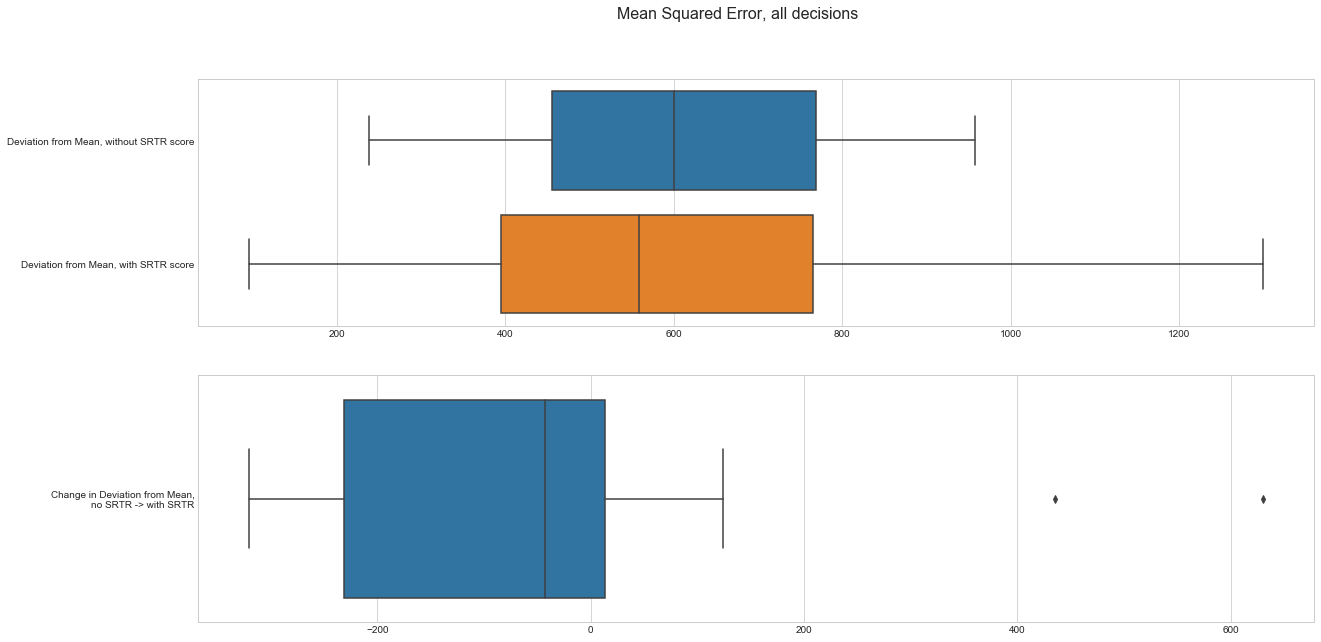

In [12]:
## Plot "mean squared error" across providers, split by Mean/SRTR Score, and by With/Without SRTR Score


df = master_data

mse_mean_blind = calculateDeviationFromMeanByObserver(df, 1, 30)
mse_mean =       calculateDeviationFromMeanByObserver(df, 31, 60)
mse_srtr_blind = calculateDeviationFromSRTRByObserver(df, 1, 30)
mse_srtr =       calculateDeviationFromSRTRByObserver(df, 31, 60)

deviations = pd.DataFrame(
               np.array([mse_mean_blind, mse_mean]),
               index=['Deviation from Mean, without SRTR score', 'Deviation from Mean, with SRTR score'])

changes = pd.DataFrame(
               np.array([mse_mean - mse_mean_blind]),
               index=['Change in Deviation from Mean, no SRTR -> with SRTR'])

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=deviations.T, orient='h')


plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=changes.T, orient='h')
ax_2.set_yticklabels([textwrap.fill(t.get_text(), 30)  for t in ax_2.get_yticklabels()])

plt.suptitle(f'Mean Squared Error, all decisions', fontsize=16)

plt.savefig('plot_BoxDeviations_all.jpg')


''

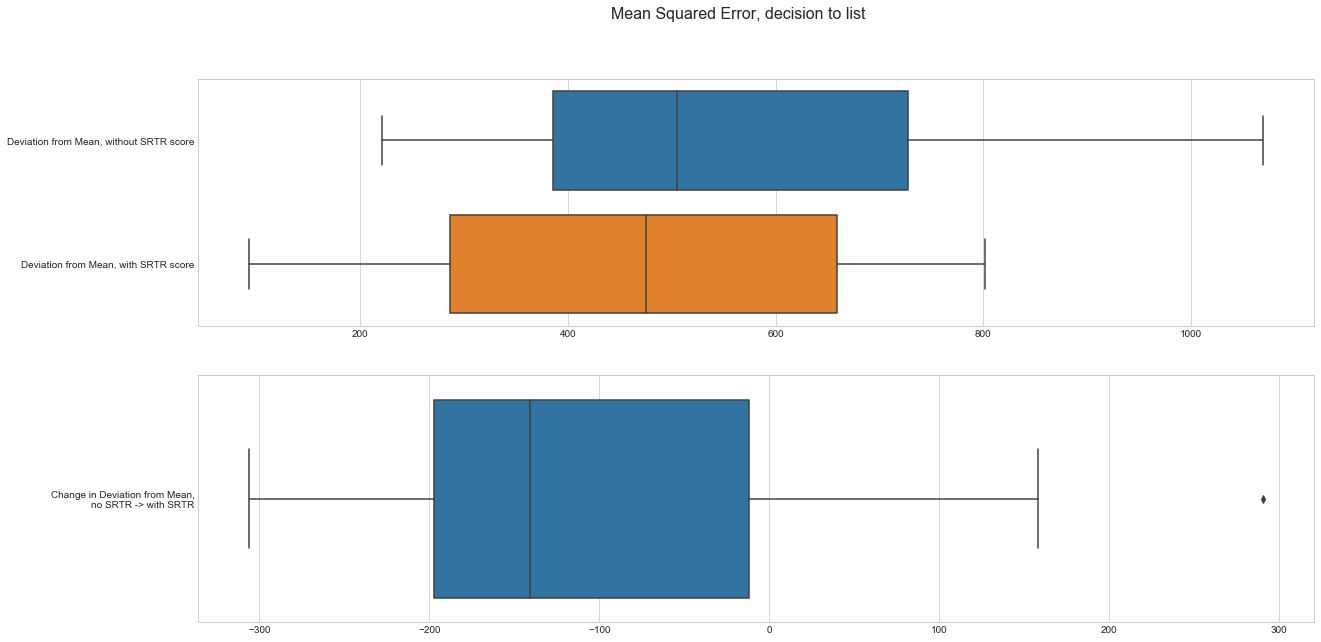

In [13]:
## Plot "mean squared error" across providers, split by Mean/SRTR Score, and by With/Without SRTR Score
#  Observers who decided to list

df = master_data[master_data['Observer Decision'] == 'Yes']

mse_mean_blind = calculateDeviationFromMeanByObserver(df, 1, 30)
mse_mean =       calculateDeviationFromMeanByObserver(df, 31, 60)
mse_srtr_blind = calculateDeviationFromSRTRByObserver(df, 1, 30)
mse_srtr =       calculateDeviationFromSRTRByObserver(df, 31, 60)

deviations = pd.DataFrame(
               np.array([mse_mean_blind, mse_mean]),
               index=['Deviation from Mean, without SRTR score', 'Deviation from Mean, with SRTR score'])

changes = pd.DataFrame(
               np.array([mse_mean - mse_mean_blind]),
               index=['Change in Deviation from Mean, no SRTR -> with SRTR'])

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=deviations.T, orient='h')


plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=changes.T, orient='h')
ax_2.set_yticklabels([textwrap.fill(t.get_text(), 30)  for t in ax_2.get_yticklabels()])

plt.suptitle(f'Mean Squared Error, decision to list', fontsize=16)
plt.savefig('plot_BoxDeviations_yes.jpg')
;

''

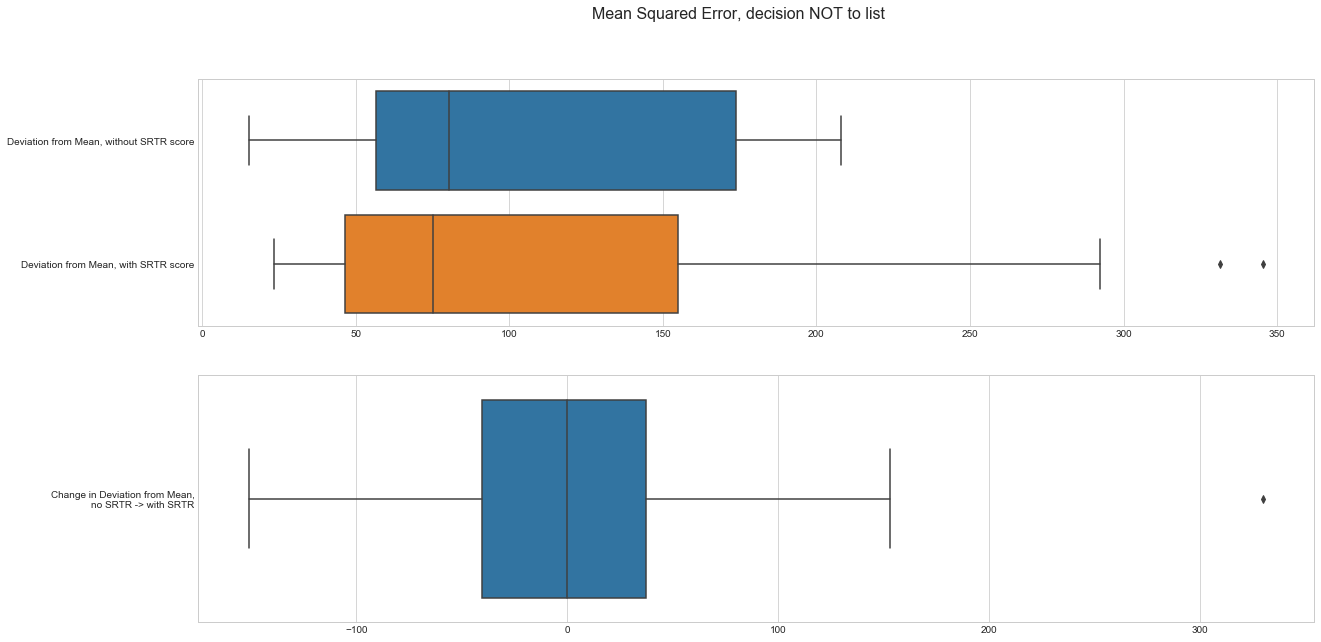

In [14]:
## Plot "mean squared error" across providers, split by Mean/SRTR Score, and by With/Without SRTR Score
#  Observers who decided NOT to list

df = master_data[master_data['Observer Decision'] == 'No']

mse_mean_blind = calculateDeviationFromMeanByObserver(df, 1, 30)
mse_mean =       calculateDeviationFromMeanByObserver(df, 31, 60)
mse_srtr_blind = calculateDeviationFromSRTRByObserver(df, 1, 30)
mse_srtr =       calculateDeviationFromSRTRByObserver(df, 31, 60)

deviations = pd.DataFrame(
               np.array([mse_mean_blind, mse_mean]),
               index=['Deviation from Mean, without SRTR score', 'Deviation from Mean, with SRTR score'])

changes = pd.DataFrame(
               np.array([mse_mean - mse_mean_blind]),
               index=['Change in Deviation from Mean, no SRTR -> with SRTR'])

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=deviations.T, orient='h')


plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=changes.T, orient='h')
ax_2.set_yticklabels([textwrap.fill(t.get_text(), 30)  for t in ax_2.get_yticklabels()])

plt.suptitle(f'Mean Squared Error, decision NOT to list', fontsize=16)
plt.savefig('plot_BoxDeviations_no.jpg')
;

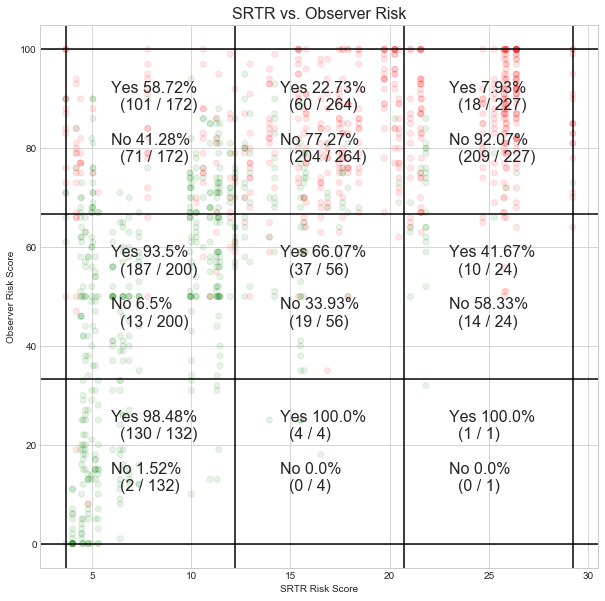

In [30]:
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(master_data['SRTR Risk'], master_data['Observer Risk'], color=colors, alpha=0.1)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')


df = master_data[['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]


#  [row, col]
#       |       |       #
# [2,0] | [2,1] | [2,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [1,0] | [1,1] | [1,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [0,0] | [0,1] | [0,2] #
#       |       |       #

# First, give each row a position in the 3x3 grid
pos_col = []
pos_row = []
for i in range(len(df)):
    obs = df['Observer Risk'].iloc[i]
    scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
    if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
        pos_col.append(0)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
        pos_col.append(0)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
        pos_col.append(0)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
        pos_col.append(1)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
        pos_col.append(1)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
        pos_col.append(1)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
        pos_col.append(2)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
        pos_col.append(2)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
        pos_col.append(2)
        pos_row.append(2)
    else:
        print(f'bing!  {i}')


srtr_min = df['SRTR Risk'].min()
srtr_max = df['SRTR Risk'].max()
srtr_range = srtr_max - srtr_min
srtr_third = srtr_range/3
text_start_x = srtr_min + srtr_third/2 - 2

obs_min = 0
obs_max = 100
obs_range = 100
obs_third = 33.3
text_start_y = obs_min + obs_third/2 - 6

plt.axvline(x=srtr_min + srtr_third, color='black')
plt.axvline(x=srtr_min + srtr_third*2, color='black')
plt.axvline(x=srtr_min, color='black')
plt.axvline(x=srtr_max, color='black')
plt.axhline(y=obs_third, color='black')
plt.axhline(y=obs_third*2, color='black')
plt.axhline(y=obs_min, color='black')
plt.axhline(y=obs_max, color='black')


df.insert(0, 'C', pos_col)
df.insert(0, 'R', pos_row)



# Second, get %Yes in each position
for row in range(3):
    for col in range(3):
        df_temp = 0
        df_y = 0
        df_n = 0
        pct_y = 0
        pct_n = 0
        N = 0
        n_y = 0
        n_n = 0
        df_temp = df[(df['R'] == row) & (df['C'] == col)]['Observer Decision']
        df_y = df_temp[df_temp == 'Yes']
        df_n = df_temp[df_temp == 'No']
        N = len(df_temp)
        if N == 0:
            pct_y = 0
            pct_n = 0
        else:
            n_y = len(df_y)
            n_n = len(df_n)
            pct_y = round(100*(n_y/N),2)
            pct_n = round(100*(n_n/N),2)
        text_x = text_start_x + srtr_third*col
        text_y = text_start_y + obs_third*row
        txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
        plt.text(text_x, text_y, txt, fontsize=16)
        # print(f'[{col}, {row}]')
        # print(f'N={N},\t% Yes = {pct_y},\t% No = {pct_n}')
        # print(f'N={N}, n_y={n_y}, %Y = {100*(n_y/N)}')

plt.title('SRTR vs. Observer Risk', fontsize=16)


plt.savefig('plot_SRTRvsObserver_all_percents.jpg')

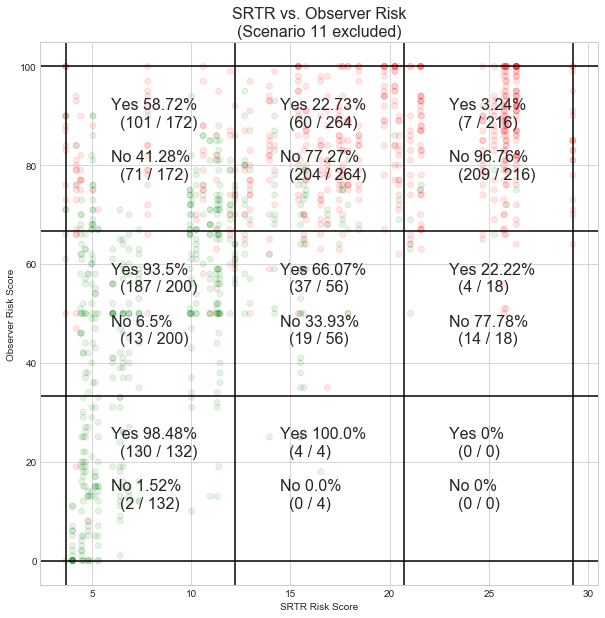

In [31]:
## Same as above, but without Scenario 11

df = master_data[master_data['Scenario ID'] != 11][['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]

colors = df['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(df['SRTR Risk'], df['Observer Risk'], color=colors, alpha=0.1)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')




#  [row, col]
#       |       |       #
# [2,0] | [2,1] | [2,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [1,0] | [1,1] | [1,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [0,0] | [0,1] | [0,2] #
#       |       |       #

# First, give each row a position in the 3x3 grid
pos_col = []
pos_row = []
for i in range(len(df)):
    obs = df['Observer Risk'].iloc[i]
    scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
    if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
        pos_col.append(0)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
        pos_col.append(0)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
        pos_col.append(0)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
        pos_col.append(1)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
        pos_col.append(1)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
        pos_col.append(1)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
        pos_col.append(2)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
        pos_col.append(2)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
        pos_col.append(2)
        pos_row.append(2)
    else:
        print(f'bing!  {i}')


srtr_min = df['SRTR Risk'].min()
srtr_max = df['SRTR Risk'].max()
srtr_range = srtr_max - srtr_min
srtr_third = srtr_range/3
text_start_x = srtr_min + srtr_third/2 - 2

obs_min = 0
obs_max = 100
obs_range = 100
obs_third = 33.3
text_start_y = obs_min + obs_third/2 - 6

plt.axvline(x=srtr_min + srtr_third, color='black')
plt.axvline(x=srtr_min + srtr_third*2, color='black')
plt.axvline(x=srtr_min, color='black')
plt.axvline(x=srtr_max, color='black')
plt.axhline(y=obs_third, color='black')
plt.axhline(y=obs_third*2, color='black')
plt.axhline(y=obs_min, color='black')
plt.axhline(y=obs_max, color='black')


df.insert(0, 'C', pos_col)
df.insert(0, 'R', pos_row)



# Second, get %Yes in each position
for row in range(3):
    for col in range(3):
        df_temp = 0
        df_y = 0
        df_n = 0
        pct_y = 0
        pct_n = 0
        N = 0
        n_y = 0
        n_n = 0
        df_temp = df[(df['R'] == row) & (df['C'] == col)]['Observer Decision']
        df_y = df_temp[df_temp == 'Yes']
        df_n = df_temp[df_temp == 'No']
        N = len(df_temp)
        if N == 0:
            pct_y = 0
            pct_n = 0
        else:
            n_y = len(df_y)
            n_n = len(df_n)
            pct_y = round(100*(n_y/N),2)
            pct_n = round(100*(n_n/N),2)
        text_x = text_start_x + srtr_third*col
        text_y = text_start_y + obs_third*row
        txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
        plt.text(text_x, text_y, txt, fontsize=16)
        # print(f'[{col}, {row}]')
        # print(f'N={N},\t% Yes = {pct_y},\t% No = {pct_n}')
        # print(f'N={N}, n_y={n_y}, %Y = {100*(n_y/N)}')

plt.title('SRTR vs. Observer Risk\n(Scenario 11 excluded)', fontsize=16)

plt.savefig('plot_SRTRvsObserver_all_percents_no11.jpg')

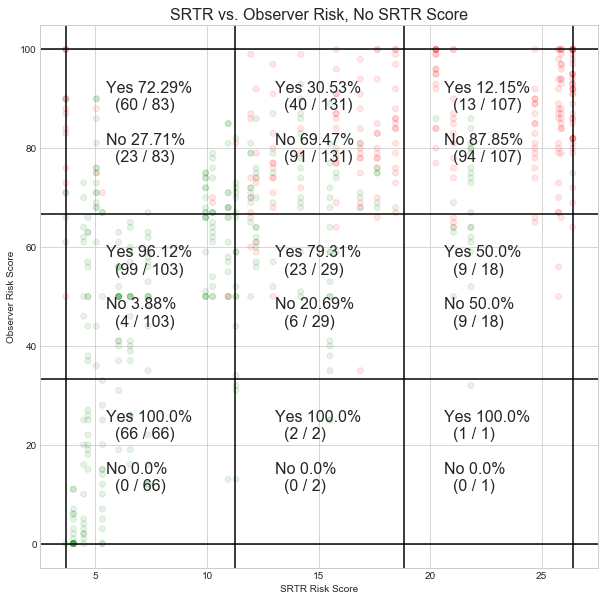

In [32]:
df_plot = master_data[master_data['Scenario Set'] == 'No SRTR Score']

colors = df_plot['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])


plt.figure(figsize=(10, 10))
plt.scatter(df_plot['SRTR Risk'], df_plot['Observer Risk'], color=colors, alpha=0.1)
# plt.scatter(master_data['SRTR Risk'], master_data[master_data['Scenario Set'] == 'With SRTR Score']['Observer Risk'], color=colors, alpha=0.1)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')


df = df_plot[['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]

#  [row, col]
#       |       |       #
# [2,0] | [2,1] | [2,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [1,0] | [1,1] | [1,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [0,0] | [0,1] | [0,2] #
#       |       |       #

# First, give each row a position in the 3x3 grid
pos_col = []
pos_row = []
for i in range(len(df)):
    obs = df['Observer Risk'].iloc[i]
    scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
    if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
        pos_col.append(0)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
        pos_col.append(0)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
        pos_col.append(0)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
        pos_col.append(1)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
        pos_col.append(1)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
        pos_col.append(1)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
        pos_col.append(2)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
        pos_col.append(2)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
        pos_col.append(2)
        pos_row.append(2)
    else:
        print(f'bing!  {i}')


srtr_min = df['SRTR Risk'].min()
srtr_max = df['SRTR Risk'].max()
srtr_range = srtr_max - srtr_min
srtr_third = srtr_range/3
text_start_x = srtr_min + srtr_third/2 - 2

obs_min = 0
obs_max = 100
obs_range = 100
obs_third = 33.3
text_start_y = obs_min + obs_third/2 - 6

plt.axvline(x=srtr_min + srtr_third, color='black')
plt.axvline(x=srtr_min + srtr_third*2, color='black')
plt.axvline(x=srtr_min, color='black')
plt.axvline(x=srtr_max, color='black')
plt.axhline(y=obs_third, color='black')
plt.axhline(y=obs_third*2, color='black')
plt.axhline(y=obs_min, color='black')
plt.axhline(y=obs_max, color='black')


df.insert(0, 'C', pos_col)
df.insert(0, 'R', pos_row)



# Second, get %Yes in each position
for row in range(3):
    for col in range(3):
        df_temp = 0
        df_y = 0
        df_n = 0
        pct_y = 0
        pct_n = 0
        N = 0
        n_y = 0
        n_n = 0
        df_temp = df[(df['R'] == row) & (df['C'] == col)]['Observer Decision']
        df_y = df_temp[df_temp == 'Yes']
        df_n = df_temp[df_temp == 'No']
        N = len(df_temp)
        if N == 0:
            pct_y = 0
            pct_n = 0
        else:
            n_y = len(df_y)
            n_n = len(df_n)
            pct_y = round(100*(n_y/N),2)
            pct_n = round(100*(n_n/N),2)
        text_x = text_start_x + srtr_third*col
        text_y = text_start_y + obs_third*row
        txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
        plt.text(text_x, text_y, txt, fontsize=16)
        # print(f'[{col}, {row}]')
        # print(f'N={N},\t% Yes = {pct_y},\t% No = {pct_n}')
        # print(f'N={N}, n_y={n_y}, %Y = {100*(n_y/N)}')



plt.title('SRTR vs. Observer Risk, No SRTR Score', fontsize=16)
plt.savefig('plot_SRTRvsObserver_NoSRTRScore_percents.jpg')


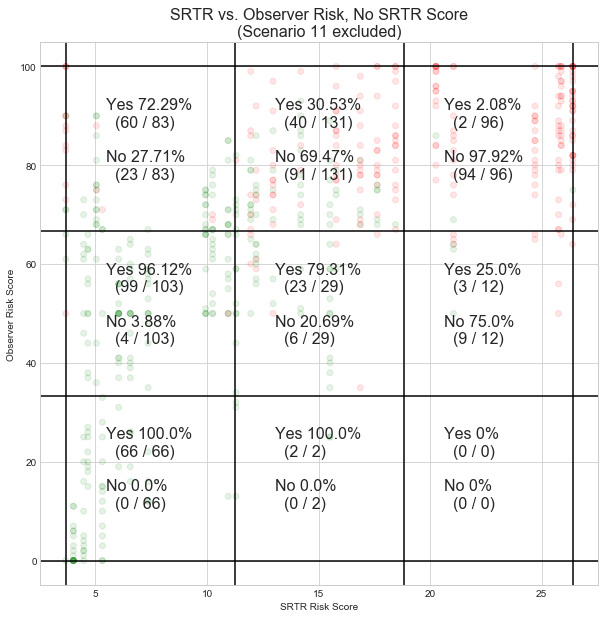

In [33]:
## Same as above, but without Scenario 11

df_plot = master_data[master_data['Scenario Set'] == 'No SRTR Score']

df = df_plot[df_plot['Scenario ID'] != 11][['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]

colors = df['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(df['SRTR Risk'], df['Observer Risk'], color=colors, alpha=0.1)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')


#  [row, col]
#       |       |       #
# [2,0] | [2,1] | [2,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [1,0] | [1,1] | [1,2] #
#       |       |       #
#-------+-------+-------#
#       |       |       #
# [0,0] | [0,1] | [0,2] #
#       |       |       #

# First, give each row a position in the 3x3 grid
pos_col = []
pos_row = []
for i in range(len(df)):
    obs = df['Observer Risk'].iloc[i]
    scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
    if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
        pos_col.append(0)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
        pos_col.append(0)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
        pos_col.append(0)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
        pos_col.append(1)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
        pos_col.append(1)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
        pos_col.append(1)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
        pos_col.append(2)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
        pos_col.append(2)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
        pos_col.append(2)
        pos_row.append(2)
    else:
        print(f'bing!  {i}')


srtr_min = df['SRTR Risk'].min()
srtr_max = df['SRTR Risk'].max()
srtr_range = srtr_max - srtr_min
srtr_third = srtr_range/3
text_start_x = srtr_min + srtr_third/2 - 2

obs_min = 0
obs_max = 100
obs_range = 100
obs_third = 33.3
text_start_y = obs_min + obs_third/2 - 6

plt.axvline(x=srtr_min + srtr_third, color='black')
plt.axvline(x=srtr_min + srtr_third*2, color='black')
plt.axvline(x=srtr_min, color='black')
plt.axvline(x=srtr_max, color='black')
plt.axhline(y=obs_third, color='black')
plt.axhline(y=obs_third*2, color='black')
plt.axhline(y=obs_min, color='black')
plt.axhline(y=obs_max, color='black')


df.insert(0, 'C', pos_col)
df.insert(0, 'R', pos_row)



# Second, get %Yes in each position
for row in range(3):
    for col in range(3):
        df_temp = 0
        df_y = 0
        df_n = 0
        pct_y = 0
        pct_n = 0
        N = 0
        n_y = 0
        n_n = 0
        df_temp = df[(df['R'] == row) & (df['C'] == col)]['Observer Decision']
        df_y = df_temp[df_temp == 'Yes']
        df_n = df_temp[df_temp == 'No']
        N = len(df_temp)
        if N == 0:
            pct_y = 0
            pct_n = 0
        else:
            n_y = len(df_y)
            n_n = len(df_n)
            pct_y = round(100*(n_y/N),2)
            pct_n = round(100*(n_n/N),2)
        text_x = text_start_x + srtr_third*col
        text_y = text_start_y + obs_third*row
        txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
        plt.text(text_x, text_y, txt, fontsize=16)
        # print(f'[{col}, {row}]')
        # print(f'N={N},\t% Yes = {pct_y},\t% No = {pct_n}')
        # print(f'N={N}, n_y={n_y}, %Y = {100*(n_y/N)}')



plt.title('SRTR vs. Observer Risk, No SRTR Score\n(Scenario 11 excluded)', fontsize=16)
plt.savefig('plot_SRTRvsObserver_NoSRTRScore_percents_no11.jpg')


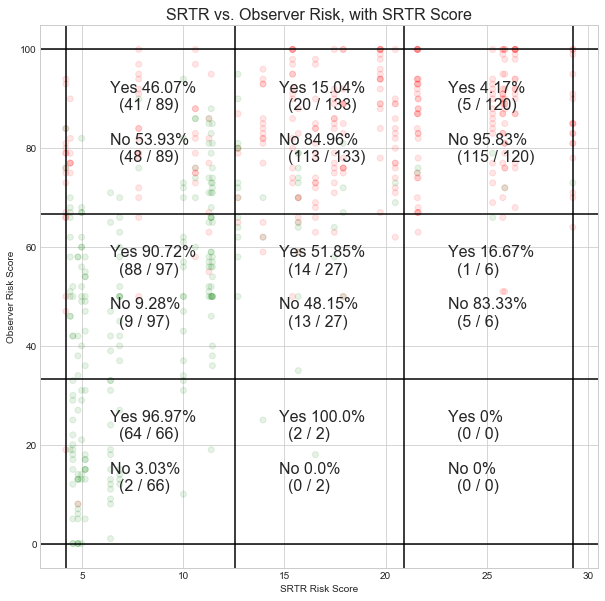

In [34]:
df_plot = master_data[master_data['Scenario Set'] == 'With SRTR Score']

colors = df_plot['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])


plt.figure(figsize=(10, 10))
plt.scatter(df_plot['SRTR Risk'], df_plot['Observer Risk'], color=colors, alpha=0.1)
# plt.scatter(master_data['SRTR Risk'], master_data[master_data['Scenario Set'] == 'With SRTR Score']['Observer Risk'], color=colors, alpha=0.1)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')


df = df_plot[['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]

# First, give each row a position in the 3x3 grid
pos_col = []
pos_row = []
for i in range(len(df)):
    obs = df['Observer Risk'].iloc[i]
    scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
    if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
        pos_col.append(0)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
        pos_col.append(0)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
        pos_col.append(0)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
        pos_col.append(1)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
        pos_col.append(1)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
        pos_col.append(1)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
        pos_col.append(2)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
        pos_col.append(2)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
        pos_col.append(2)
        pos_row.append(2)
    else:
        print(f'bing!  {i}')


srtr_min = df['SRTR Risk'].min()
srtr_max = df['SRTR Risk'].max()
srtr_range = srtr_max - srtr_min
srtr_third = srtr_range/3
text_start_x = srtr_min + srtr_third/2 - 2

obs_min = 0
obs_max = 100
obs_range = 100
obs_third = 33.3
text_start_y = obs_min + obs_third/2 - 6

plt.axvline(x=srtr_min + srtr_third, color='black')
plt.axvline(x=srtr_min + srtr_third*2, color='black')
plt.axvline(x=srtr_min, color='black')
plt.axvline(x=srtr_max, color='black')
plt.axhline(y=obs_third, color='black')
plt.axhline(y=obs_third*2, color='black')
plt.axhline(y=obs_min, color='black')
plt.axhline(y=obs_max, color='black')


df.insert(0, 'C', pos_col)
df.insert(0, 'R', pos_row)



# Second, get %Yes in each position
for row in range(3):
    for col in range(3):
        df_temp = 0
        df_y = 0
        df_n = 0
        pct_y = 0
        pct_n = 0
        N = 0
        n_y = 0
        n_n = 0
        df_temp = df[(df['R'] == row) & (df['C'] == col)]['Observer Decision']
        df_y = df_temp[df_temp == 'Yes']
        df_n = df_temp[df_temp == 'No']
        N = len(df_temp)
        if N == 0:
            pct_y = 0
            pct_n = 0
        else:
            n_y = len(df_y)
            n_n = len(df_n)
            pct_y = round(100*(n_y/N),2)
            pct_n = round(100*(n_n/N),2)
        text_x = text_start_x + srtr_third*col
        text_y = text_start_y + obs_third*row
        txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
        plt.text(text_x, text_y, txt, fontsize=16)

plt.title('SRTR vs. Observer Risk, with SRTR Score', fontsize=16)
plt.savefig('plot_SRTRvsObserver_WithSRTRScore_percents.jpg')


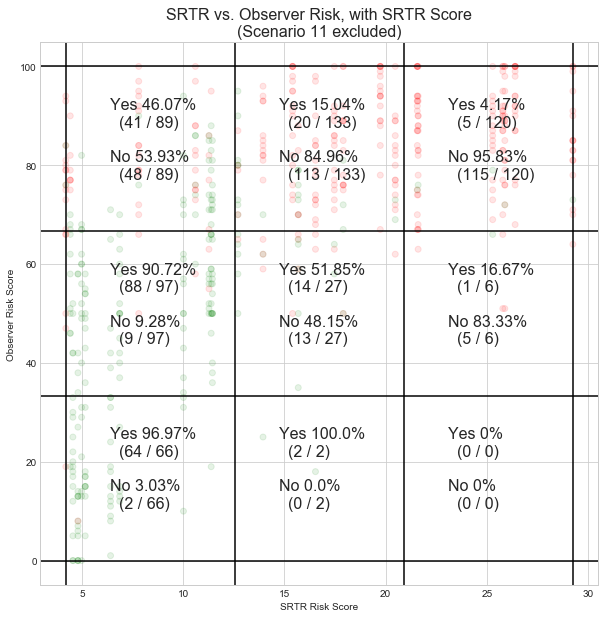

In [35]:
## Same as above, but without Scenario 11

df_plot = master_data[master_data['Scenario Set'] == 'With SRTR Score']

df = df_plot[df_plot['Scenario ID'] != 11][['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]

colors = df['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(df['SRTR Risk'], df['Observer Risk'], color=colors, alpha=0.1)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')


# First, give each row a position in the 3x3 grid
pos_col = []
pos_row = []
for i in range(len(df)):
    obs = df['Observer Risk'].iloc[i]
    scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
    if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
        pos_col.append(0)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
        pos_col.append(0)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
        pos_col.append(0)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
        pos_col.append(1)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
        pos_col.append(1)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
        pos_col.append(1)
        pos_row.append(2)
    elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
        pos_col.append(2)
        pos_row.append(0)
    elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
        pos_col.append(2)
        pos_row.append(1)
    elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
        pos_col.append(2)
        pos_row.append(2)
    else:
        print(f'bing!  {i}')


srtr_min = df['SRTR Risk'].min()
srtr_max = df['SRTR Risk'].max()
srtr_range = srtr_max - srtr_min
srtr_third = srtr_range/3
text_start_x = srtr_min + srtr_third/2 - 2

obs_min = 0
obs_max = 100
obs_range = 100
obs_third = 33.3
text_start_y = obs_min + obs_third/2 - 6

plt.axvline(x=srtr_min + srtr_third, color='black')
plt.axvline(x=srtr_min + srtr_third*2, color='black')
plt.axvline(x=srtr_min, color='black')
plt.axvline(x=srtr_max, color='black')
plt.axhline(y=obs_third, color='black')
plt.axhline(y=obs_third*2, color='black')
plt.axhline(y=obs_min, color='black')
plt.axhline(y=obs_max, color='black')


df.insert(0, 'C', pos_col)
df.insert(0, 'R', pos_row)



# Second, get %Yes in each position
for row in range(3):
    for col in range(3):
        df_temp = 0
        df_y = 0
        df_n = 0
        pct_y = 0
        pct_n = 0
        N = 0
        n_y = 0
        n_n = 0
        df_temp = df[(df['R'] == row) & (df['C'] == col)]['Observer Decision']
        df_y = df_temp[df_temp == 'Yes']
        df_n = df_temp[df_temp == 'No']
        N = len(df_temp)
        if N == 0:
            pct_y = 0
            pct_n = 0
        else:
            n_y = len(df_y)
            n_n = len(df_n)
            pct_y = round(100*(n_y/N),2)
            pct_n = round(100*(n_n/N),2)
        text_x = text_start_x + srtr_third*col
        text_y = text_start_y + obs_third*row
        txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
        plt.text(text_x, text_y, txt, fontsize=16)

plt.title('SRTR vs. Observer Risk, with SRTR Score\n(Scenario 11 excluded)', fontsize=16)
plt.savefig('plot_SRTRvsObserver_WithSRTRScore_percents_no11.jpg')


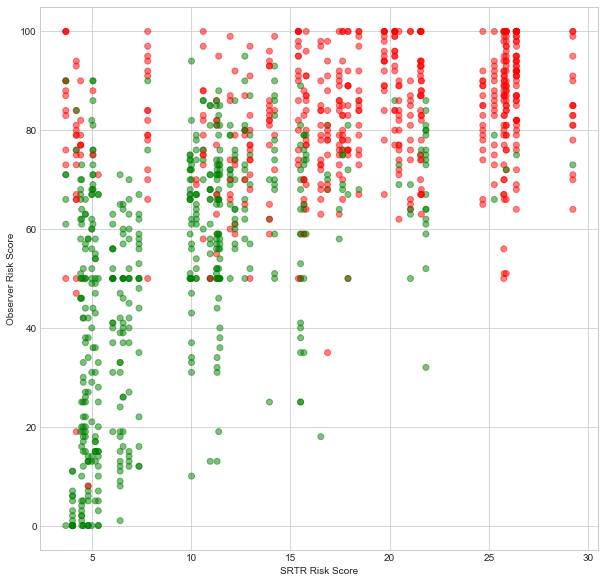

In [18]:
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(master_data['SRTR Risk'], master_data['Observer Risk'], color=colors, alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

plt.savefig('plot_SRTRvsObserver_all.jpg')

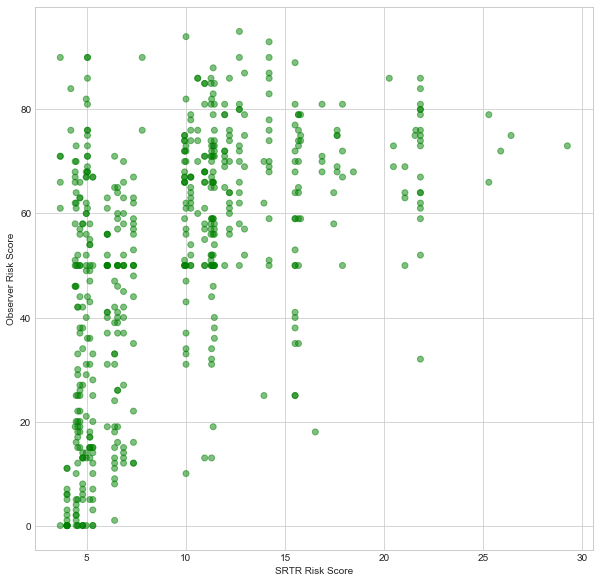

In [19]:
decision_yes = master_data['Observer Decision'] == 'Yes'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_yes]['SRTR Risk'], master_data[decision_yes]['Observer Risk'], color=colors[decision_yes], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

plt.savefig('plot_SRTRvsObserver_yes.jpg')

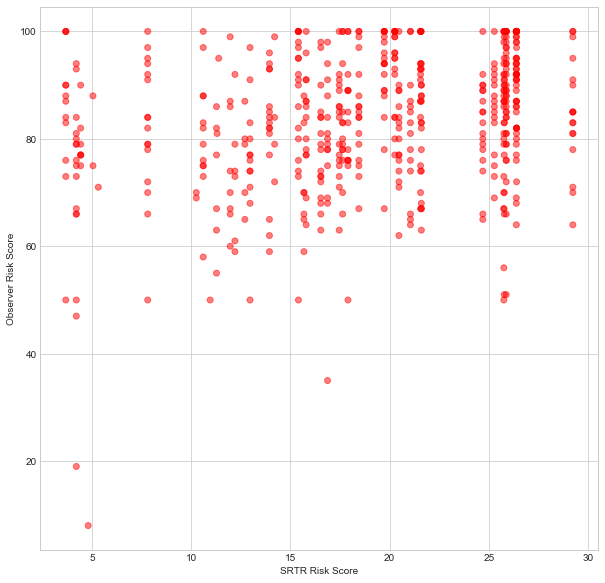

In [20]:
decision_no = master_data['Observer Decision'] == 'No'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_no]['SRTR Risk'], master_data[decision_no]['Observer Risk'], color=colors[decision_no], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

plt.savefig('plot_SRTRvsObserver_no.jpg')

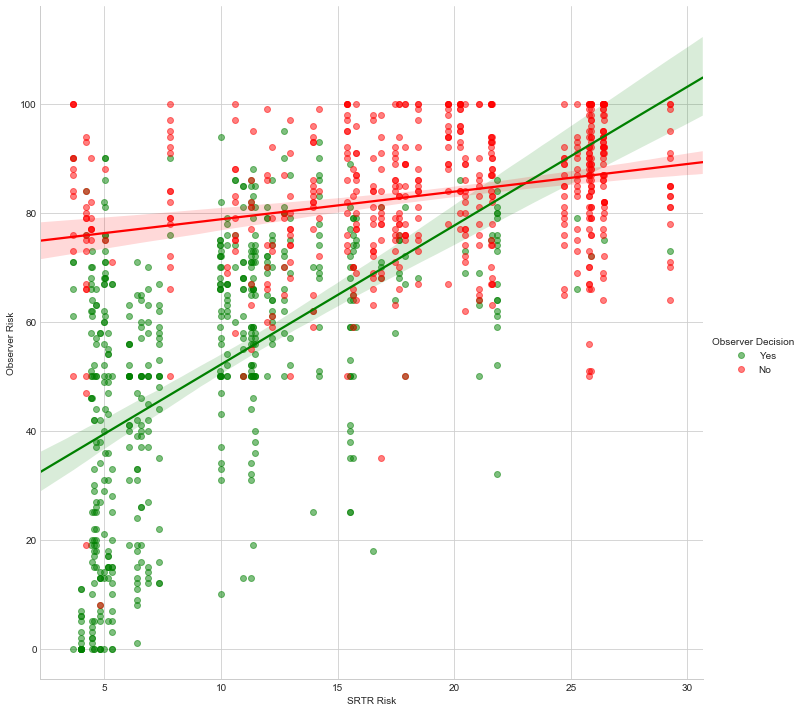

In [21]:
sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data, hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_all.jpg')

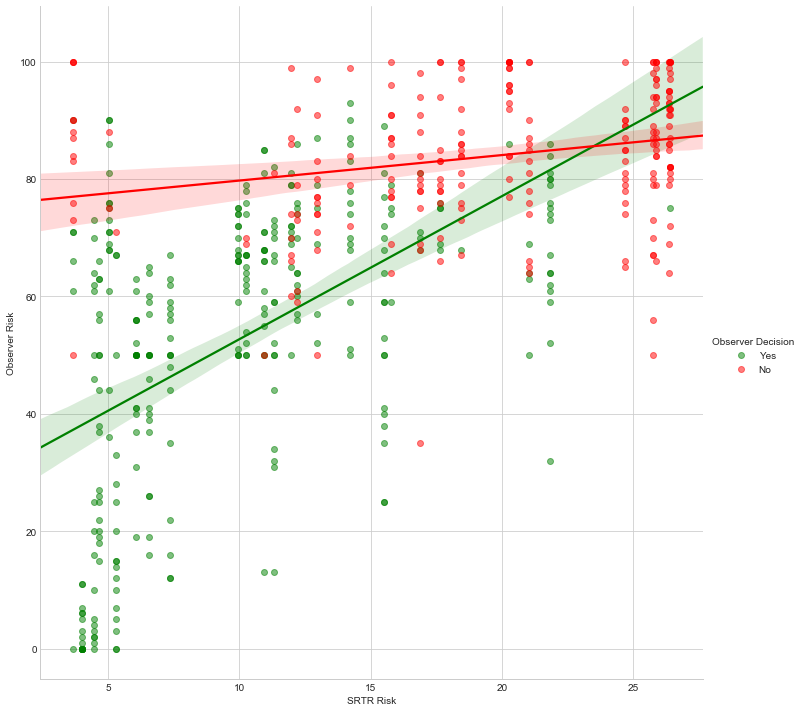

In [22]:
sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[master_data['Scenario ID'] <= 30], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_all_1-30.jpg')

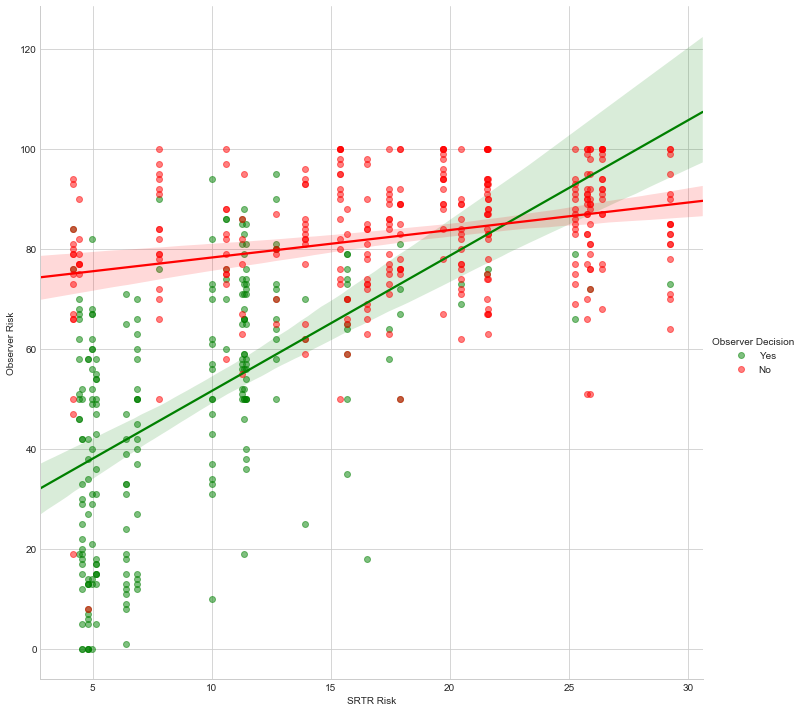

In [23]:
sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[master_data['Scenario ID'] > 30], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_all_31-60.jpg')

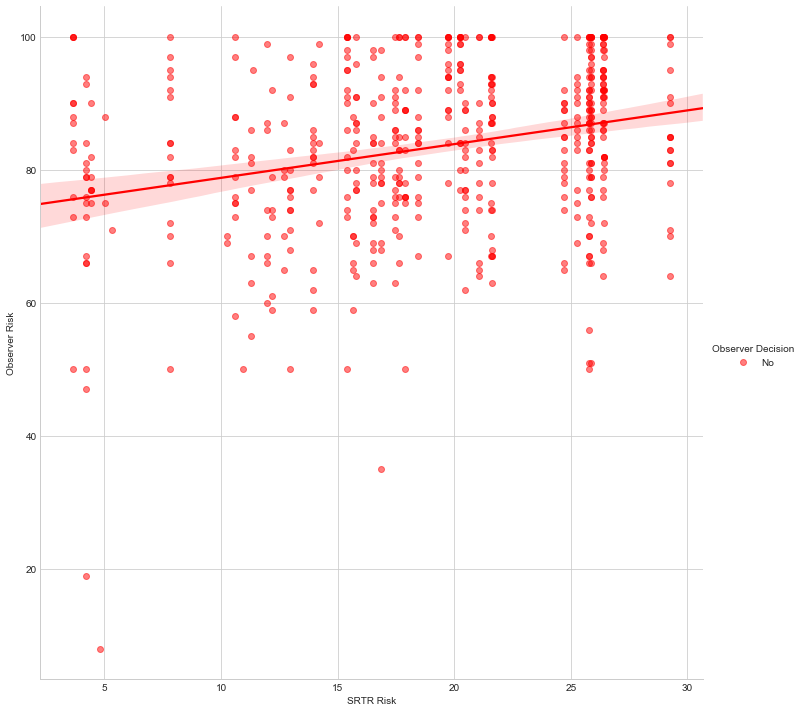

In [24]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_no.jpg')

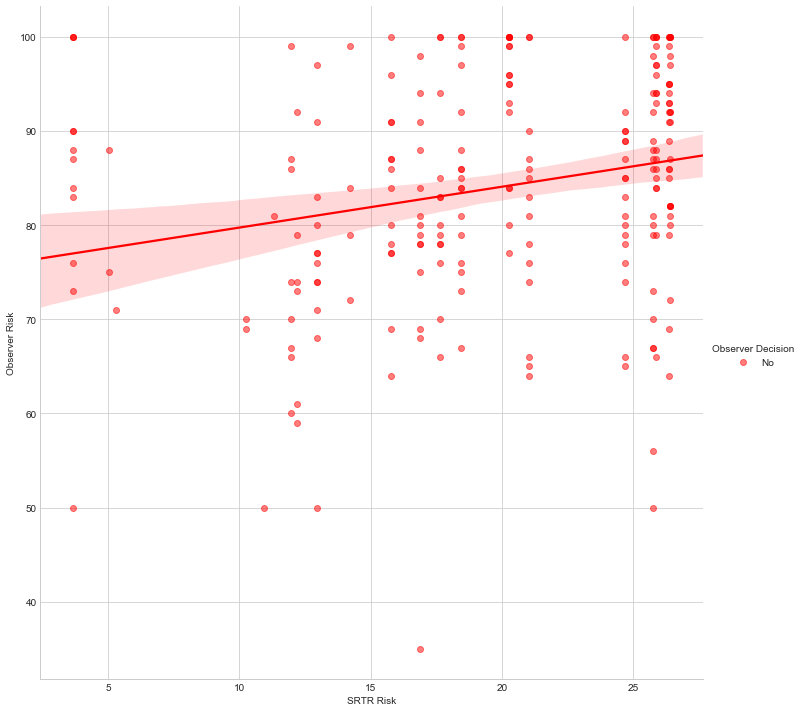

In [25]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no & (master_data['Scenario ID'] <= 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_no_1-30.jpg')

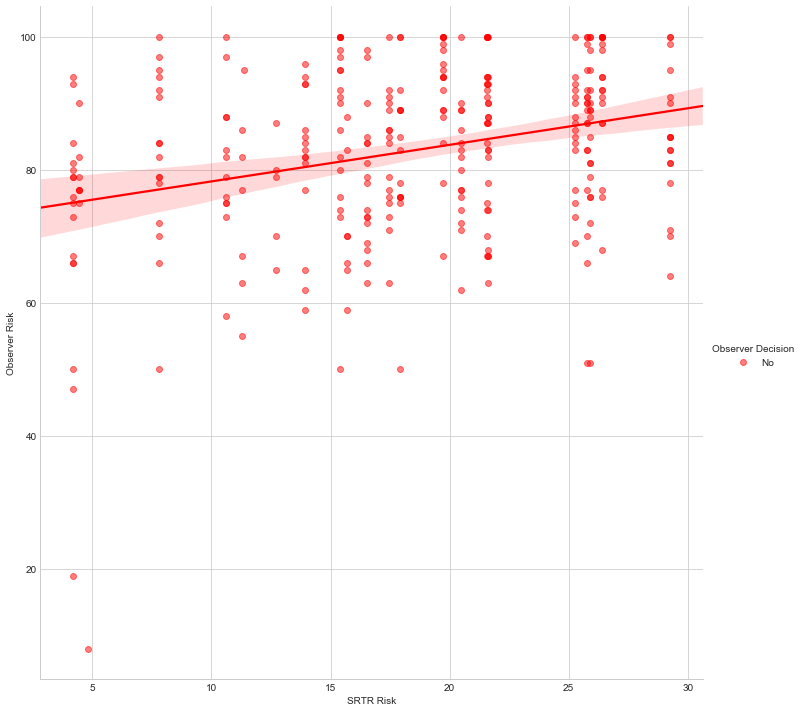

In [26]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no & (master_data['Scenario ID'] > 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_no_31-60.jpg')

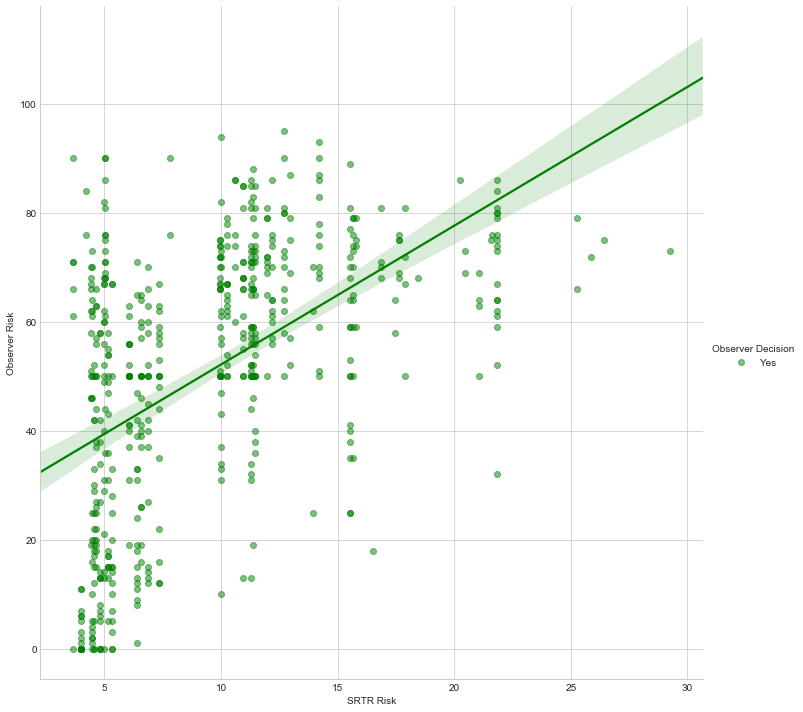

In [27]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_yes.jpg')

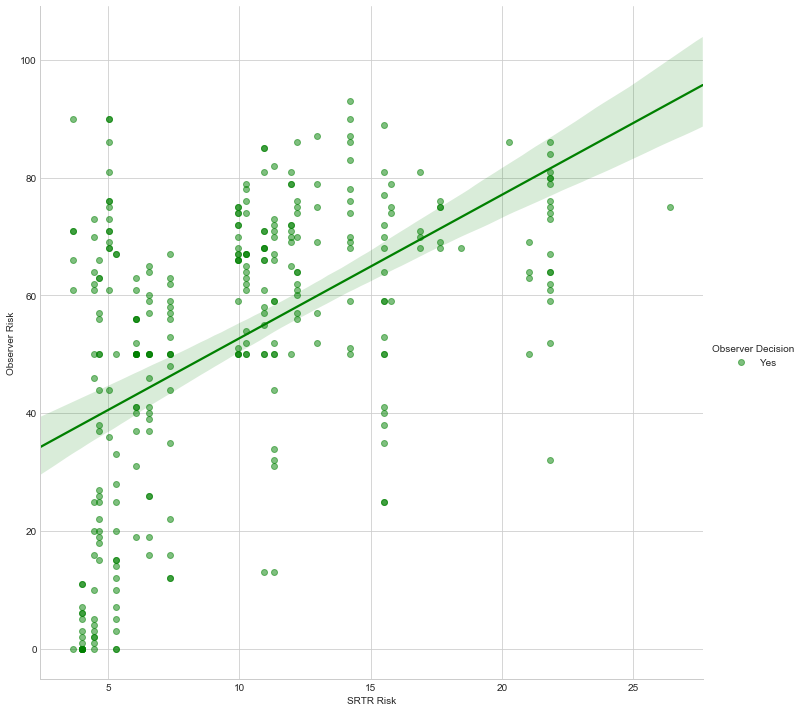

In [28]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes & (master_data['Scenario ID'] <= 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_yes_1-30.jpg')

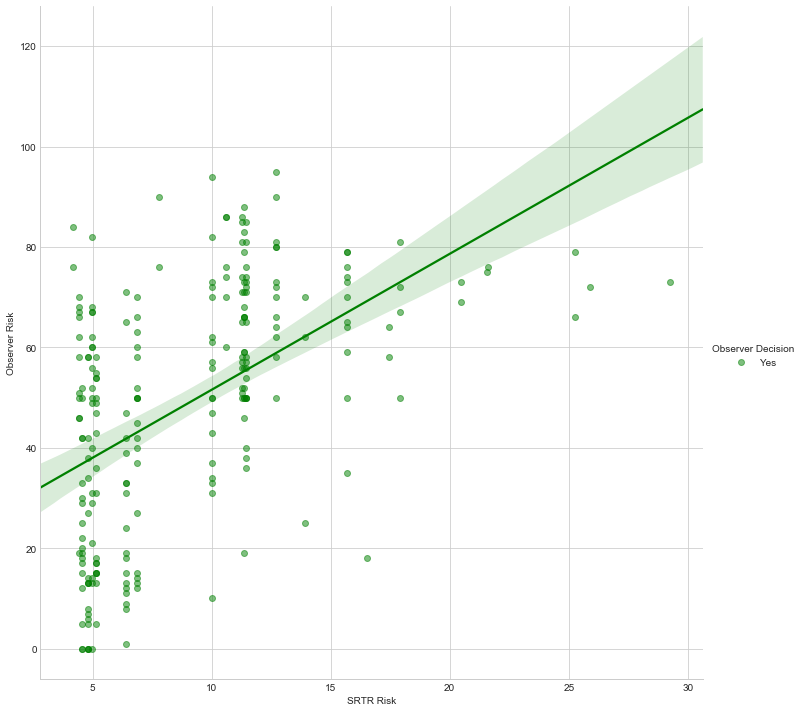

In [29]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes & (master_data['Scenario ID'] > 30)], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)

plt.savefig('plot_SRTRvsObserver_fit_yes_31-60.jpg')

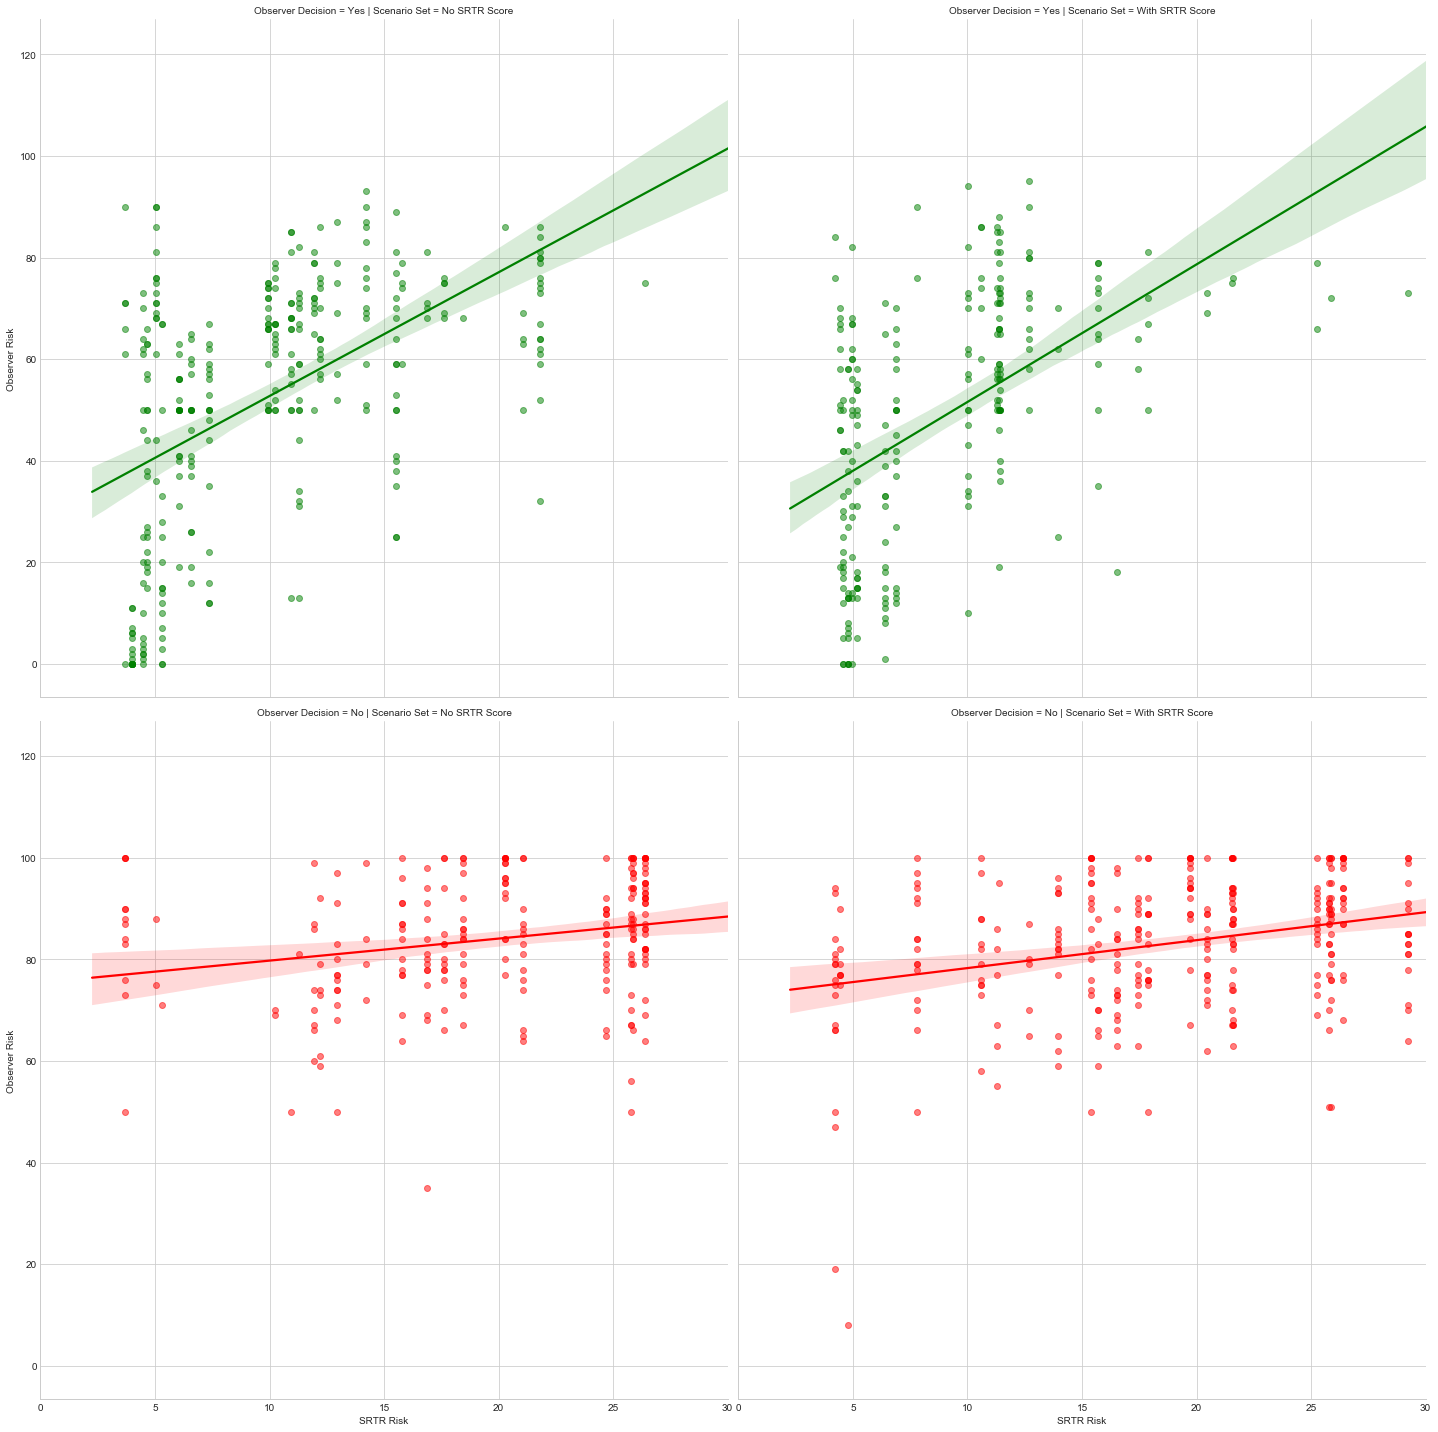

In [30]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", row='Observer Decision', col='Scenario Set', data=master_data, hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5}, size=10)
fit_yes.set(xlim=(0, 30))

plt.savefig('plot_SRTRvsObserver_fit_sliced.jpg')

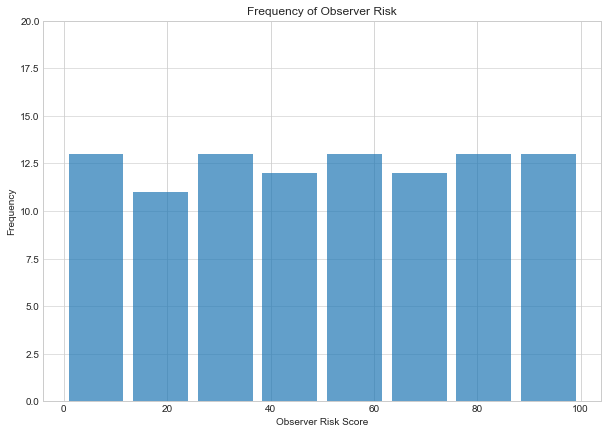

In [31]:
plt.figure(figsize=(10, 7))

df = master_data['Observer Risk'].drop_duplicates()

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Observer Risk Score')
plt.ylabel('Frequency')
plt.title('Frequency of Observer Risk')
maxfreq = n.max()
# Set a clean upper y-axis limit.

plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('histogram_ObserverRisk.jpg')

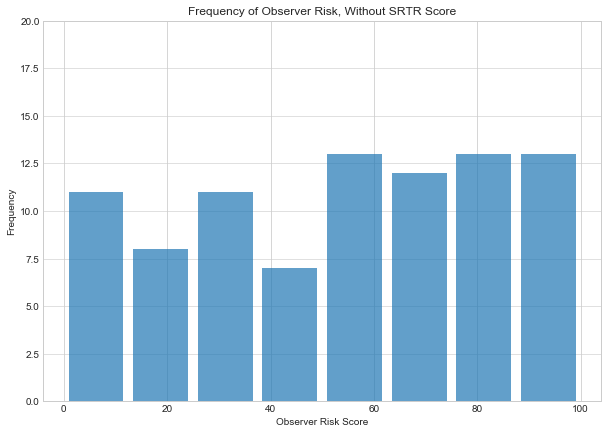

In [32]:
plt.figure(figsize=(10, 7))

df = master_data[master_data['Scenario Set'] == 'No SRTR Score']['Observer Risk'].drop_duplicates()

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Observer Risk Score')
plt.ylabel('Frequency')
plt.title('Frequency of Observer Risk, Without SRTR Score')
maxfreq = n.max()
# Set a clean upper y-axis limit.

plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('histogram_ObserverRisk_noscore.jpg')

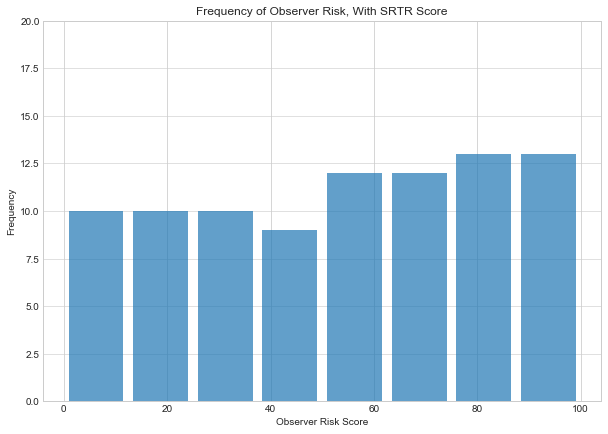

In [33]:
plt.figure(figsize=(10, 7))

df = master_data[master_data['Scenario Set'] == 'With SRTR Score']['Observer Risk'].drop_duplicates()

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Observer Risk Score')
plt.ylabel('Frequency')
plt.title('Frequency of Observer Risk, With SRTR Score')
maxfreq = n.max()
# Set a clean upper y-axis limit.

plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('histogram_ObserverRisk_withscore.jpg')

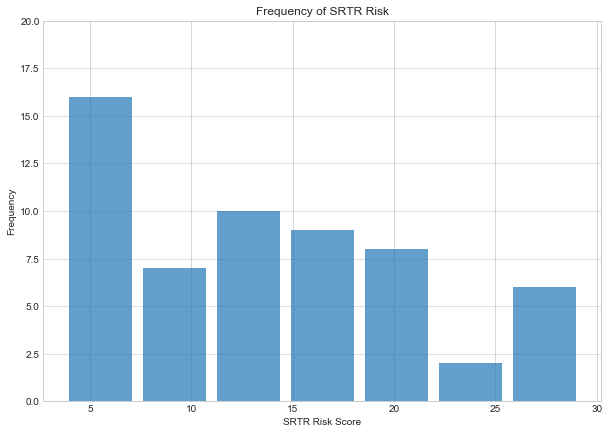

In [34]:
plt.figure(figsize=(10, 7))

df = master_data['SRTR Risk'].drop_duplicates()

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Frequency')
plt.title('Frequency of SRTR Risk')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('histogram_SRTRRisk.jpg')

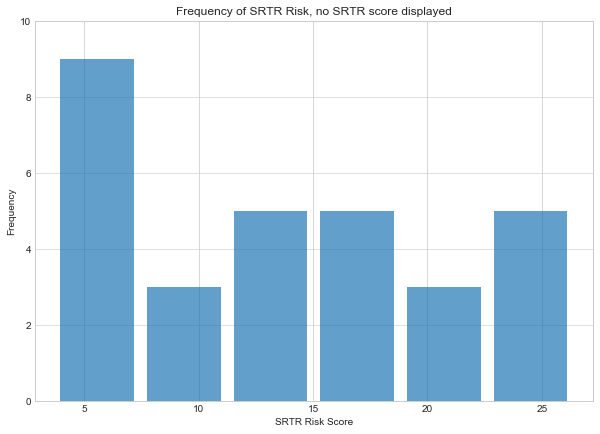

In [35]:
plt.figure(figsize=(10, 7))

df = master_data[master_data['Scenario Set'] == 'No SRTR Score']['SRTR Risk'].drop_duplicates()

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Frequency')
plt.title('Frequency of SRTR Risk, no SRTR score displayed')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('histogram_SRTRRisk_noscore.jpg')

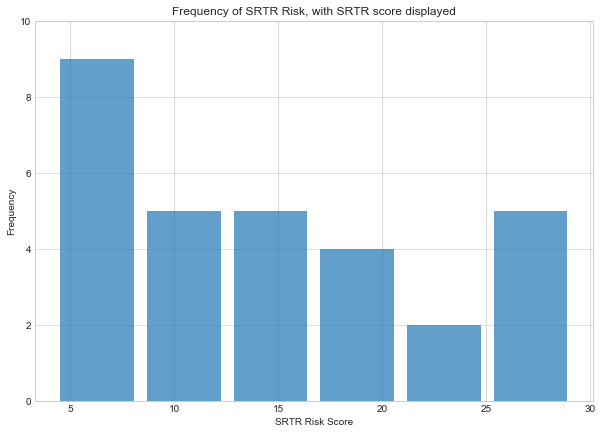

In [36]:
plt.figure(figsize=(10, 7))

df = master_data[master_data['Scenario Set'] == 'With SRTR Score']['SRTR Risk'].drop_duplicates()

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=df, bins='auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Frequency')
plt.title('Frequency of SRTR Risk, with SRTR score displayed')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig('histogram_SRTRRisk_withscore.jpg')

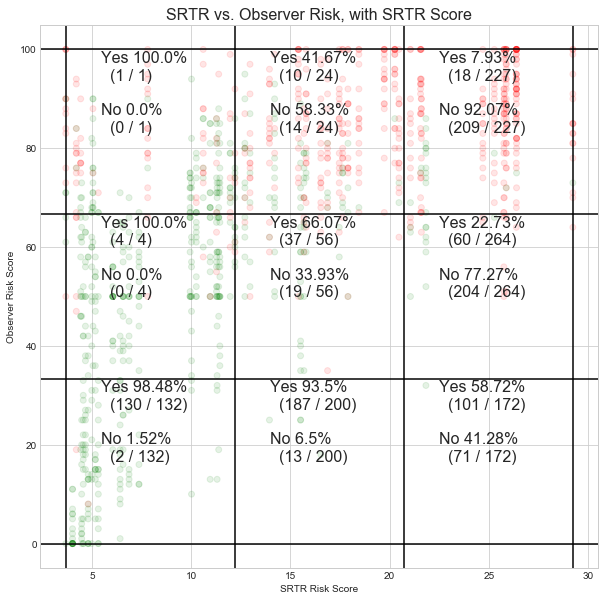

In [14]:

# First, give each row a position in the 3x3 grid
def getGridPositions(df):
    pos_col = []
    pos_row = []
    for i in range(len(df)):
        obs = df['Observer Risk'].iloc[i]
        scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
        if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
            pos_col.append(0)
            pos_row.append(0)
        elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
            pos_col.append(1)
            pos_row.append(0)
        elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
            pos_col.append(2)
            pos_row.append(0)
        elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
            pos_col.append(0)
            pos_row.append(1)
        elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
            pos_col.append(1)
            pos_row.append(1)
        elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
            pos_col.append(2)
            pos_row.append(1)
        elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
            pos_col.append(0)
            pos_row.append(2)
        elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
            pos_col.append(1)
            pos_row.append(2)
        elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
            pos_col.append(2)
            pos_row.append(2)
        else:
            print(f'bing!  {i}')
    return { 'row': pos_row, 'col': pos_col }

def prependGridPositions(df):
    df_temp = df[['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]
    positions = getGridPositions(df_temp)
    df_temp.insert(0, 'R', positions['row'])
    df_temp.insert(0, 'C', positions['col'])
    return df_temp


def plotTernaryPercents(df):
    df_pos = prependGridPositions(df)
    srtr_min = df_pos['SRTR Risk'].min()
    srtr_max = df_pos['SRTR Risk'].max()
    srtr_range = srtr_max - srtr_min
    srtr_third = srtr_range/3
    obs_min = 0
    obs_max = 100
    obs_range = 100
    obs_third = 33.3
    text_start_x = srtr_min + srtr_third/2 - 2.5
    text_start_y = obs_min + obs_third/2
    colors = df_pos['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pos['SRTR Risk'], df_pos['Observer Risk'], color=colors, alpha=0.1)
    plt.xlabel('SRTR Risk Score')
    plt.ylabel('Observer Risk Score')
    for col in range(3):
        for row in range(3):
            df_temp = df_pos[(df_pos['C'] == col) & (df_pos['R'] == row)]['Observer Decision']
            df_y = df_temp[df_temp == 'Yes']
            df_n = df_temp[df_temp == 'No']
            N = len(df_temp)
            if N == 0:
                pct_y = 0
                pct_n = 0
            else:
                n_y = len(df_y)
                n_n = len(df_n)
                pct_y = round(100*(n_y/N),2)
                pct_n = round(100*(n_n/N),2)
            text_x = text_start_x + srtr_third*col
            text_y = text_start_y + obs_third*row
            txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
            plt.text(text_x, text_y, txt, fontsize=16)
    plt.title('SRTR vs. Observer Risk, with SRTR Score', fontsize=16)
    plt.axvline(x=srtr_min + srtr_third, color='black')
    plt.axvline(x=srtr_min + srtr_third*2, color='black')
    plt.axvline(x=srtr_min, color='black')
    plt.axvline(x=srtr_max, color='black')
    plt.axhline(y=obs_third, color='black')
    plt.axhline(y=obs_third*2, color='black')
    plt.axhline(y=obs_min, color='black')
    plt.axhline(y=obs_max, color='black')




plotTernaryPercents(master_data)



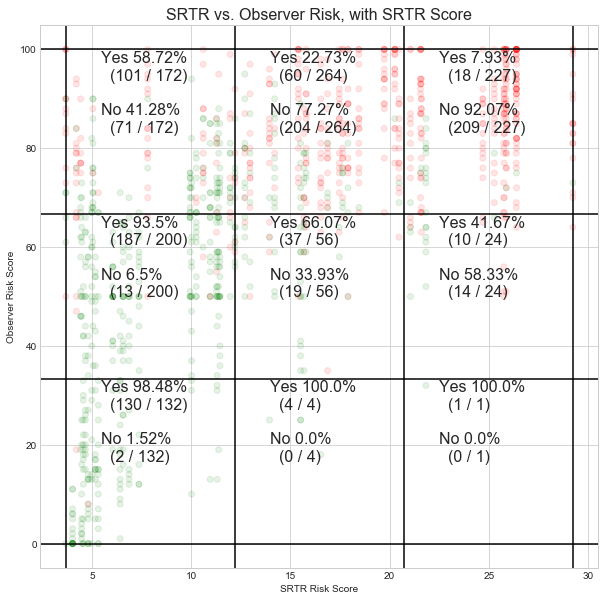

In [18]:
# First, give each row a position in the 3x3 grid
def getGridPositions(df):
    pos_col = []
    pos_row = []
    for i in range(len(df)):
        obs = df['Observer Risk'].iloc[i]
        scaled_srtr = df['Scaled SRTR Risk'].iloc[i]
        if ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[0, 0]
            pos_col.append(0)
            pos_row.append(0)
        elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[1, 0]
            pos_col.append(0)
            pos_row.append(1)
        elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr >= 0)  & (scaled_srtr <= 100/3)  ): #[2, 0]
            pos_col.append(0)
            pos_row.append(2)
        elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[0, 1]
            pos_col.append(1)
            pos_row.append(0)
        elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[1, 1]
            pos_col.append(1)
            pos_row.append(1)
        elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 100/3) & (scaled_srtr <= 200/3)  ): #[2, 1]
            pos_col.append(1)
            pos_row.append(2)
        elif ( (obs >= 0)  & (obs <= 100/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[0, 2]
            pos_col.append(2)
            pos_row.append(0)
        elif ( (obs > 100/3) & (obs <= 200/3)  ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[1, 2]
            pos_col.append(2)
            pos_row.append(1)
        elif ( (obs > 200/3) & (obs <= 100) ) & ( (scaled_srtr > 200/3) & (scaled_srtr <= 100) ): #[2, 2]
            pos_col.append(2)
            pos_row.append(2)
        else:
            print(f'bing!  {i}')
    return { 'row': pos_row, 'col': pos_col }


def prependGridPositions(df):
    df_temp = df[['Observer Risk', 'Scaled SRTR Risk', 'SRTR Risk', 'Observer Decision']]
    positions = getGridPositions(df_temp)
    df_temp.insert(0, 'R', positions['row'])
    df_temp.insert(0, 'C', positions['col'])
    return df_temp

def plotTernaryPercents(df):
    df_pos = prependGridPositions(df)
    srtr_min = df_pos['SRTR Risk'].min()
    srtr_max = df_pos['SRTR Risk'].max()
    srtr_range = srtr_max - srtr_min
    srtr_third = srtr_range/3
    obs_min = 0
    obs_max = 100
    obs_range = 100
    obs_third = 33.3
    text_start_x = srtr_min + srtr_third/2 - 2.5
    text_start_y = obs_min + obs_third/2
    colors = df_pos['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])
    plt.figure(figsize=(10, 10))
    plt.scatter(df_pos['SRTR Risk'], df_pos['Observer Risk'], color=colors, alpha=0.1)
    plt.xlabel('SRTR Risk Score')
    plt.ylabel('Observer Risk Score')
    for col in range(3):
        for row in range(3):
            df_temp = df_pos[(df_pos['C'] == col) & (df_pos['R'] == row)]['Observer Decision']
            df_y = df_temp[df_temp == 'Yes']
            df_n = df_temp[df_temp == 'No']
            N = len(df_temp)
            if N == 0:
                pct_y = 0
                pct_n = 0
            else:
                n_y = len(df_y)
                n_n = len(df_n)
                pct_y = round(100*(n_y/N),2)
                pct_n = round(100*(n_n/N),2)
            text_x = text_start_x + srtr_third*col
            text_y = text_start_y + obs_third*row
            txt = f'Yes {pct_y}%\n  ({n_y} / {N})\n\nNo {pct_n}%\n  ({n_n} / {N})'
            #txt = f'Col: {col}\nRow: {row}'
            plt.text(text_x, text_y, txt, fontsize=16)
    plt.title('SRTR vs. Observer Risk, with SRTR Score', fontsize=16)
    plt.axvline(x=srtr_min + srtr_third, color='black')
    plt.axvline(x=srtr_min + srtr_third*2, color='black')
    plt.axvline(x=srtr_min, color='black')
    plt.axvline(x=srtr_max, color='black')
    plt.axhline(y=obs_third, color='black')
    plt.axhline(y=obs_third*2, color='black')
    plt.axhline(y=obs_min, color='black')
    plt.axhline(y=obs_max, color='black')
plotTernaryPercents(master_data)
#prependGridPositions(master_data)
